# Naive approach

This file is the implementation of the "naive" approach. According to our expert, the data follows an exponential formula being $-k * e^((-1/tau)*x) + k$. We fit the parameter k and tau on existing data. These parameter are fitted for each slope occuring in the data. Therefore, we plot the parameters per difference in input and fit a quadratic or exponential function therefore.

With these functions, we can detect the parameters k and tau before the experiment by using the differences in input. Having k and tau we can put them back in the exponential formulas providing a first approximation.

## Preliminaries

In [1]:
#need the following specification, so all tables are left and not centered

In [2]:
%%html
<style>
    table {float:left}
</style>

### Import libraries

In [3]:
# own libraries
import Global_Functions as gf
import Data_Processing as dp
#python libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import metrics
import time
timestr = time.strftime("%Y-%m-%d_%H-%M/")

In [4]:
np.random.seed(123)

### Open data

In [5]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [6]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [7]:
experiments = [ex_1, ex_4, ex_9, ex_20, ex_21, ex_22, ex_23, ex_24]
names = ['1', '4', '9', '20', '21','22', '23', '24']

In [8]:
#this is needed, to apply the same name for every experiment which differ due to the preprocessing
for exp in experiments:
    spin_head = exp.filter(regex = ("spin.*"))
    exp['spin_power'] = spin_head

In [9]:
OPEN_SYNTHETIC = '../Data/Synthetic_Data/Without_Noise/Sample_Ratio_1/quadratic_40_0_linear_1'

In [10]:
experiments = gf.load_synthetic(OPEN_SYNTHETIC, length = 50)
names = [str(x+1) for x in range(len(experiments)-1)]
names.append("hand")

### Specify saving folder

In [11]:
image_folder = "../Images/Naive_Approach/" + timestr
gf.check_folder(image_folder)

Creation of directory ../Images/Naive_Approach/2021-05-24_12-46/ successful.


In [12]:
train = "6"
val = "all"

ex_train = experiments[5]
ex_val = gf.use_multiple_experiments(experiments[0:])
#ex_test = #gf.use_multiple_experiments(experiments[15:20])

In [13]:
specs = {
    'data': 'Synthetic - (40, 0, 1)',
    'data_points': 'Exp. 6 for training - all other for validation',
    'sampling_rate': 1
}

specs_str = ""
for cat, descr in specs.items():
    specs_str += f'{cat}: {descr} \n'

with open(image_folder + "00_specs.txt", "w") as text_file:
    text_file.write(specs_str)

## Stationary parameters

One possibility is to use known parameters for power and spinning according to the corresponding input. With this simple approximation we ignore transition phases. We use them to show our naive approach is still better than just the stationary fit.

In [14]:
def stationary_fit(experiment):
    fit_voltage = [3,5,7.5, 10]
    fit_spin = [3103, 3250, 3604, 3961]
    fit_el = [1200, 1637, 2509, 3300]
    fit_th = [10480, 11700, 14700, 18690]

    prm_fit_st_th, pcov_th = scipy.optimize.curve_fit(gf.quadr_func, fit_voltage, fit_th, maxfev = 3000)
    prm_fit_st_el, pcov_el = scipy.optimize.curve_fit(gf.quadr_func, fit_voltage, fit_el, maxfev = 3000)
    prm_fit_st_spin, pcov_spin = scipy.optimize.curve_fit(gf.quadr_func, fit_voltage, fit_spin, maxfev = 3000)
    
    p1, p2, p3 = prm_fit_st_th
    experiment['th_pred'] = gf.quadr_func(experiment['input_voltage'], p1, p2, p3)
    p1, p2, p3 = prm_fit_st_el
    experiment['el_pred'] = gf.quadr_func(experiment['input_voltage'], p1, p2, p3)
    p1, p2, p3 = prm_fit_st_spin
    experiment['spin_pred'] = gf.quadr_func(experiment['input_voltage'], p1, p2, p3)
    
    return experiment

## Methods for approximation

In [15]:
# approximate values by using the exponential function. Adapt if necessary
def approximation(time, values):
    assert len(time) == len(values), 'time and values should have the same length'
    segment_start_value = values[0]
    param_bounds = ([-np.inf, -np.inf], [np.inf, np.inf])
    para_fit, pcov = scipy.optimize.curve_fit(gf.exp_func, time - time[0], values- segment_start_value, bounds=param_bounds, maxfev = 3000000)
    k_best = para_fit[0]
    tau_best = para_fit[1]
    return k_best, tau_best

In [16]:
def all_approximations(data_time, data_input, data_value, time_splits):
#     fig,axs = plt.subplots(math.ceil(len(time_splits)/2), 2, figsize = (20,12))
#     axs = axs.ravel()
    approximations = np.full(shape = len(data_time), fill_value= np.nan)
    parameters = []
    
    start = time.time()
    
    for t in range(len(time_splits) -1):
        cut_point_prior = math.ceil(time_splits[t])
        cut_point_post = math.ceil(time_splits[t+1])
        time_segment = np.array(data_time[cut_point_prior:cut_point_post])
        value_segment = np.array(data_value[cut_point_prior:cut_point_post])
        input_start = data_input[cut_point_prior]
        input_end = data_input[cut_point_post -1]
       
        k_best, tau_best = approximation(time_segment,
                                  value_segment)
        segment_approximation = gf.exp_func(time_segment-time_segment[0], k_best, tau_best) + value_segment[0]
        approximations[cut_point_prior:cut_point_post] = segment_approximation
        prs = [input_start, input_end, k_best, tau_best]
        parameters = np.concatenate((parameters, prs), axis = 0)
        
#         axs[t].plot(time_segment, value_segment)
#         axs[t].plot(time_segment, segment_approximation)
        
        
    end = time.time()
    duration = end - start
#     axs[-1].plot(data_time, data_value)
#     axs[-1].plot(data_time, approximations)
    
    return approximations, parameters.reshape(len(time_splits) -1, 4), duration

In [17]:
def get_time_splits(df):
    time_splits = [x for x in range(len(df)-1) if df.iloc[x]['input_voltage'] != df.iloc[x+1]['input_voltage']]
    if len(time_splits) > 20:
        time_splits = time_splits[::2]
    time_splits.append(len(df))
    if time_splits[0] != 0:
        time_splits.insert(0,0)
    return time_splits

## Comparison of fits 

We compare all experiments according to their fits. This was initially done to compare the exponential fit to the stationary fit. We discovered that in all experiments the exponential fit is far better than the stationary fit. Therefore, we focused on improving the fit by includign the modelling of the fitting parameters.

Comparison of the approaches and fits compared to true values:

Variable|Approach|RMSE|R^2|MAE|MaxAE
---|----|----:|----:|---:|---:
**Spinning**|**exponential**|**37.264**|**0.987**|**23.183**|**129.704**
Spinning|stationary|210.845|0.570|98.725|868.402
**Electric**|**exponential**|**109.274**|**0.982**|**72.463**|**375.395**
Electric|stationary| 518.049|0.589|239.259|2166.749
**Thermal**|**exponential**|**1105.615**|**0.882**|**925.458**|**3662.547**
Thermal|stationary|2444.558|0.423|1618.027|10083.339

In [18]:
def compare_fits(experiment, name, images = False):
    #values = ['spin', 'el', 'th']
    values = ['el']
    parameters = []
    duration = []
    
    time_splits = get_time_splits(experiment)
    
    experiment = stationary_fit(experiment)
    
    for n in values:
        experiment[str(n + '_approx')], pms, dur = all_approximations(experiment['time'], experiment['input_voltage'], experiment[str(n +'_power')], time_splits)
        parameters.append(pms)
        duration.append(dur)
        
        if images:
            fig, axs = plt.subplots(figsize = (15,10))
            line1, = axs.plot(experiment['time'], experiment[str(n +'_power')], color = gf.get_color('grey'), label = 'true')
            line2, = axs.plot(experiment['time'], experiment[str(n +'_approx')], color = gf.get_color('orange'), label = 'exponential fit')
            line3, = axs.plot(experiment['time'], experiment[str(n +'_pred')], color = gf.get_color('cyan'), label = 'stationary fit')
            axs.set_title('Comparison of fits on ' + n + ' on ' + name, fontsize = 25)
            axs.set_xlabel('time [sec]', fontsize = 18)
            axs.set_ylabel(n , fontsize = 18)
            axs.legend([line1, line2, line3], ['true', 'exponential fit', 'stationary fit'], loc = 'upper right')

            fig.savefig(image_folder + name + "_" + n + "_fits.png")
            fig.savefig(image_folder + name + "_" + n + "_fits.svg")
        
        print('-------------- Differences on ' + name + ' ' + n + ' stationary fit----------------')
        gf.measure_difference(experiment[str(n + '_power')], experiment[str(n + '_pred')])
        print('-------------- Differences on ' + name + ' ' + n + ' exponential fit ----------------')
        gf.measure_difference(experiment[str(n + '_power')], experiment[str(n + '_approx')])        

        
    return parameters, duration

# Meta Model
Since the exponential fits show promising results we decided to try to predict the fits. We did so by fitting one existing experiment and mapping the parameters k and tau of each slope to the according difference in input. We found the best describing function for this mapping with the information of our expert, that the stationary phases (k) have quadratic terms and the steepness (tau) is linear.

In [19]:
def df_out_of_fitting_parameters(params):
    df_params = pd.DataFrame(params)
    df_params.columns = ['input_start', 'input_end', 'k_best', 'tau_best']
    df_params['Input_diff'] = [df_params.iloc[x]['input_end'] - df_params.iloc[x]['input_start'] for x in range(len(df_params))]
    return df_params

In [20]:
def parameter_modelling(df_params, func_k, func_tau, name, images = False):
    prm_fit_k, pcov_k = scipy.optimize.curve_fit(func_k, df_params['Input_diff'], df_params['k_best'])
    prm_fit_tau, pcov_tau = scipy.optimize.curve_fit(func_tau, df_params['Input_diff'], df_params['tau_best'])
    
    tau1, tau2, tau3 = prm_fit_tau
    k1, k2 = prm_fit_k
    
    input_default = np.arange(-7.0, 7.0, 0.2)
    
    if images:
        fig,axs = plt.subplots(1, 2, figsize = (8,5))
        axs = axs.ravel()
        axs[1].scatter(df_params['Input_diff'], df_params['tau_best'], label = 'tau')
        axs[1].plot(input_default, func_tau(input_default, tau1, tau2, tau3), color = gf.get_color('orange'))
        axs[1].set_title('tau over input difference for ' + name)
        axs[1].set_ylabel('tau')
        axs[1].set_xlabel('input difference')
        axs[0].scatter(df_params['Input_diff'], df_params['k_best'], label ='k')
        axs[0].plot(input_default, func_k(input_default, k1, k2), color = gf.get_color('orange'))
        axs[0].set_title('k over input difference for ' + name)
        axs[0].set_ylabel('k')
        axs[0].set_xlabel('input difference')

        plt.savefig(image_folder + name + "_k_tau.png")
        plt.savefig(image_folder + name + "_k_tau.svg")
    
    return prm_fit_k, prm_fit_tau

In [21]:
def train_meta_modell(train_experiment, train_name):
    parameters, dur = compare_fits(train_experiment, train_name)
    #name_categories = ['_spin', '_electric', '_thermal']
    name_categories = "_electric"
    models = []
    for i in range(len(parameters)):
        df_p = df_out_of_fitting_parameters(parameters[i])
        mod = parameter_modelling(df_p, gf.linear_func, gf.quadr_func, name_categories[i], images = True)
        models.append(mod)
    return models

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Global_Functions.py:180: RuntimeWarning: overflow encountered in exp
  return -k* np.exp((-1/tau)*x) +k
C:\Users\FlorianLeiser\anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


-------------- Differences on train on 6 el stationary fit----------------
The RMSE is 792.470
The R2-score is -21.960
The MAE is 750.479
The MaxAE is 2201.338
-------------- Differences on train on 6 el exponential fit ----------------
The RMSE is 21.086
The R2-score is 0.984
The MAE is 10.247
The MaxAE is 94.340


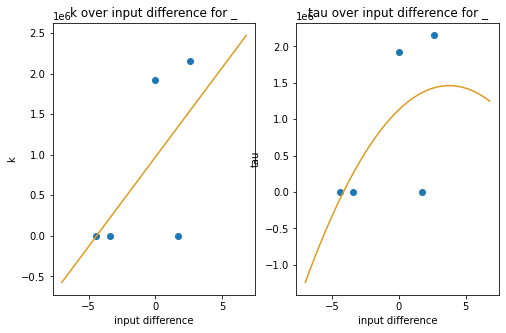

In [22]:
models_1 = train_meta_modell(ex_train, "train on " + train)

Our expert stated, that there are quadratic relationships between the outputs and the input so they might reflect on the parameters. The scatter plots suggest a quadratic relationship of tau to the difference and a linear relationship of k to the input difference.

## Prediction with fitted parameters 

In [23]:
def predict_other_experiment(model_parameters, data):
    start = time.time()
    time_splits = get_time_splits(data)
    data_time = data['time']
    data_input = data['input_voltage']
    
    #header = ['spin', 'el', 'th']
    header = ['el']
    durations = []
    
    for i in range(len(header)):
        parameters_k, parameters_tau = model_parameters[i]
        data_value = data[str(header[i] + '_power')]
        
        prm_k = np.empty(3)
        prm_tau = np.empty(3)
        prm_k[0], prm_k[1] = parameters_k
        prm_tau[0], prm_tau[1], prm_tau[2] = parameters_tau

        approximations = np.full(shape = len(data_time), fill_value= np.nan)

        for t in range(len(time_splits) -1):
            cut_point_prior = math.ceil(time_splits[t])
            cut_point_post = math.ceil(time_splits[t+1])
            time_segment = np.array(data_time[cut_point_prior:cut_point_post])
            value_segment = np.array(data_value[cut_point_prior:cut_point_post])
            input_start = data_input[cut_point_prior]
            input_end = data_input[cut_point_post -1]
            input_diff = input_end - input_start

            k = gf.linear_func(input_diff, prm_k[0], prm_k[1])
            tau = gf.quadr_func(input_diff, prm_tau[0], prm_tau[1], prm_tau[2])

            segment_approximation = gf.exp_func(time_segment-time_segment[0], k, tau) + value_segment[0]
            approximations[cut_point_prior:cut_point_post] = segment_approximation

        end = time.time()
        dur = end-start
        durations.append(dur)
        
        data[str(header[i] + '_predictions')] = approximations
    return data, durations

### On seen and unseen experiments

In [24]:
def compare_predictions(experiment, name, model_parameters, values = ['spin', 'el', 'th']):
    ex_predicted, durations = predict_other_experiment(model_parameters, experiment)
    

    all_results = []
    for n in values:
        fig, axs = plt.subplots(figsize = (15,10))
        line1, = axs.plot(experiment['time'], experiment[str(n +'_power')], color = gf.get_color('grey'), label = 'true')
        line2, = axs.plot(experiment['time'], experiment[str(n +'_predictions')], color = gf.get_color('green'), label = 'predictions')
        axs.set_title('Validation of ' + n + ' on ' + name, fontsize = 25)
        axs.set_xlabel('time [sec]', fontsize = 18)
        axs.set_ylabel(n , fontsize = 18)
        axs.legend([line1, line2], ['true', 'predictions'], loc = 'upper right')

        fig.savefig(image_folder + name + "_" + n + "_predictions.png")
        fig.savefig(image_folder + name + "_" + n + "_predictions.svg")
        
        print('-------------- Differences on ' + name + ' ' + n + ' predictions ----------------')
        results = gf.measure_difference(experiment[str(n + '_power')], experiment[str(n + '_predictions')])
        all_results.append(results['RMSE'])
    return all_results

-------------- Differences on 1 el predictions ----------------
The RMSE is 746.179
The R2-score is 0.488
The MAE is 602.997
The MaxAE is 1619.529
-------------- Differences on 2 el predictions ----------------
The RMSE is 1541.263
The R2-score is -121.230
The MAE is 1229.171
The MaxAE is 3203.703
-------------- Differences on 3 el predictions ----------------
The RMSE is 999.440
The R2-score is -0.238
The MAE is 672.767
The MaxAE is 3086.780
-------------- Differences on 4 el predictions ----------------
The RMSE is 1968.797
The R2-score is -4.945
The MAE is 1353.257
The MaxAE is 4176.942
-------------- Differences on 5 el predictions ----------------
The RMSE is 1101.451
The R2-score is -13.042
The MAE is 921.304
The MaxAE is 2300.668
-------------- Differences on 6 el predictions ----------------
The RMSE is 1404.256
The R2-score is -71.095
The MAE is 850.770
The MaxAE is 3582.810
-------------- Differences on 7 el predictions ----------------
The RMSE is 967.666
The R2-score is -0.

<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 21 el predictions ----------------
The RMSE is 732.586
The R2-score is -10.648
The MAE is 567.930
The MaxAE is 1614.201


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 22 el predictions ----------------
The RMSE is 2225.484
The R2-score is -6131240884034381564431631690760192.000
The MAE is 1927.537
The MaxAE is 3852.521


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 23 el predictions ----------------
The RMSE is 4902.150
The R2-score is -116207167527430568919747168043008.000
The MAE is 4246.831
The MaxAE is 8481.255


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 24 el predictions ----------------
The RMSE is 3428.817
The R2-score is -11.643
The MAE is 2391.893
The MaxAE is 6971.314


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 25 el predictions ----------------
The RMSE is 1521.520
The R2-score is -0.873
The MAE is 963.573
The MaxAE is 4211.900


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 26 el predictions ----------------
The RMSE is 4592.620
The R2-score is -101995417453969336601879399890944.000
The MAE is 3978.580
The MaxAE is 7946.271


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 27 el predictions ----------------
The RMSE is 1879.745
The R2-score is -380.978
The MAE is 1595.242
The MaxAE is 3685.948


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 28 el predictions ----------------
The RMSE is 759.726
The R2-score is -0.549
The MAE is 542.022
The MaxAE is 1952.257


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 29 el predictions ----------------
The RMSE is 1647.516
The R2-score is -4.218
The MAE is 1232.431
The MaxAE is 3581.686


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 30 el predictions ----------------
The RMSE is 1109.919
The R2-score is 0.000
The MAE is 961.190
The MaxAE is 1921.745


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 31 el predictions ----------------
The RMSE is 680.890
The R2-score is 0.369
The MAE is 535.986
The MaxAE is 1647.631


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 32 el predictions ----------------
The RMSE is 1205.403
The R2-score is -2.304
The MAE is 780.819
The MaxAE is 3155.232


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 33 el predictions ----------------
The RMSE is 1815.490
The R2-score is -18.360
The MAE is 1400.848
The MaxAE is 3770.022


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 34 el predictions ----------------
The RMSE is 824.573
The R2-score is -821973788393135383561673637888.000
The MAE is 714.038
The MaxAE is 1427.725


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 35 el predictions ----------------
The RMSE is 4205.525
The R2-score is 0.000
The MAE is 3643.126
The MaxAE is 7277.124


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 36 el predictions ----------------
The RMSE is 647.220
The R2-score is -1.724
The MAE is 445.773
The MaxAE is 1770.589


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 37 el predictions ----------------
The RMSE is 1140.581
The R2-score is -17.792
The MAE is 884.337
The MaxAE is 2514.215


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 38 el predictions ----------------
The RMSE is 1198.076
The R2-score is -444230793387183559306569752510464.000
The MAE is 1037.550
The MaxAE is 2074.360


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 39 el predictions ----------------
The RMSE is 4227.833
The R2-score is -43.972
The MAE is 2595.659
The MaxAE is 12016.062


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 40 el predictions ----------------
The RMSE is 753.608
The R2-score is -2.123
The MAE is 520.935
The MaxAE is 1987.796


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 41 el predictions ----------------
The RMSE is 1368.506
The R2-score is -0.126
The MAE is 1111.894
The MaxAE is 2646.663


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 42 el predictions ----------------
The RMSE is 4933.935
The R2-score is -55.369
The MAE is 2208.346
The MaxAE is 20209.104


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 43 el predictions ----------------
The RMSE is 744.601
The R2-score is 0.540
The MAE is 572.749
The MaxAE is 1791.039


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 44 el predictions ----------------
The RMSE is 972.639
The R2-score is -1.153
The MAE is 787.205
The MaxAE is 1998.415


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 45 el predictions ----------------
The RMSE is 1396.190
The R2-score is -2.374
The MAE is 885.385
The MaxAE is 3945.819


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 46 el predictions ----------------
The RMSE is 3966.155
The R2-score is -7439.367
The MAE is 3327.849
The MaxAE is 7108.130


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 47 el predictions ----------------
The RMSE is 1722.443
The R2-score is -13.794
The MAE is 1366.150
The MaxAE is 3482.886


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 48 el predictions ----------------
The RMSE is 1375.527
The R2-score is -5.420
The MAE is 1049.519
The MaxAE is 3040.078


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on 49 el predictions ----------------
The RMSE is 2989.182
The R2-score is -43208012501514946411318424371200.000
The MAE is 2589.176
The MaxAE is 5173.744


<ipython-input-24-cf8f058a6f4c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (15,10))


-------------- Differences on hand el predictions ----------------
The RMSE is 1469.312
The R2-score is -16.830
The MAE is 1242.076
The MaxAE is 3240.167


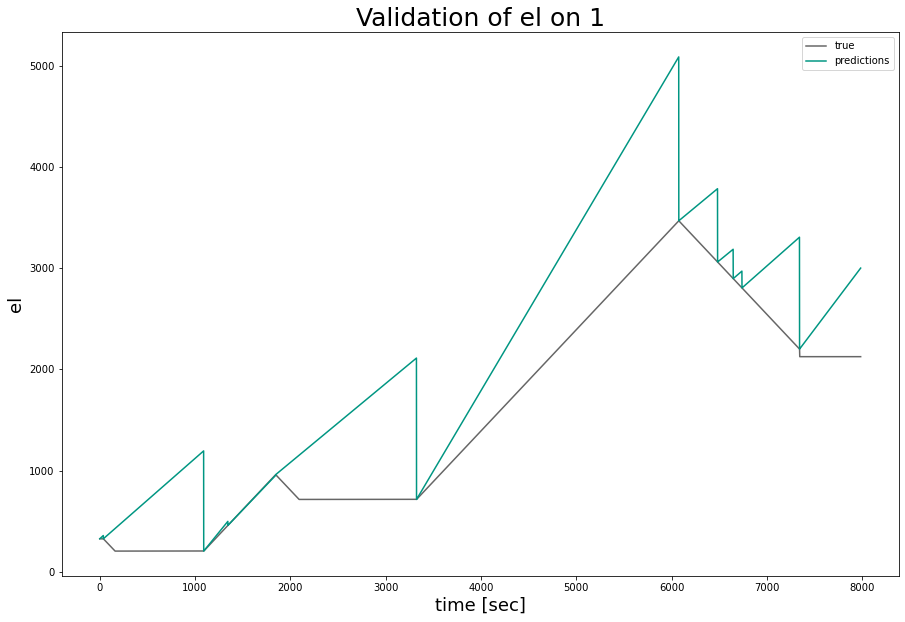

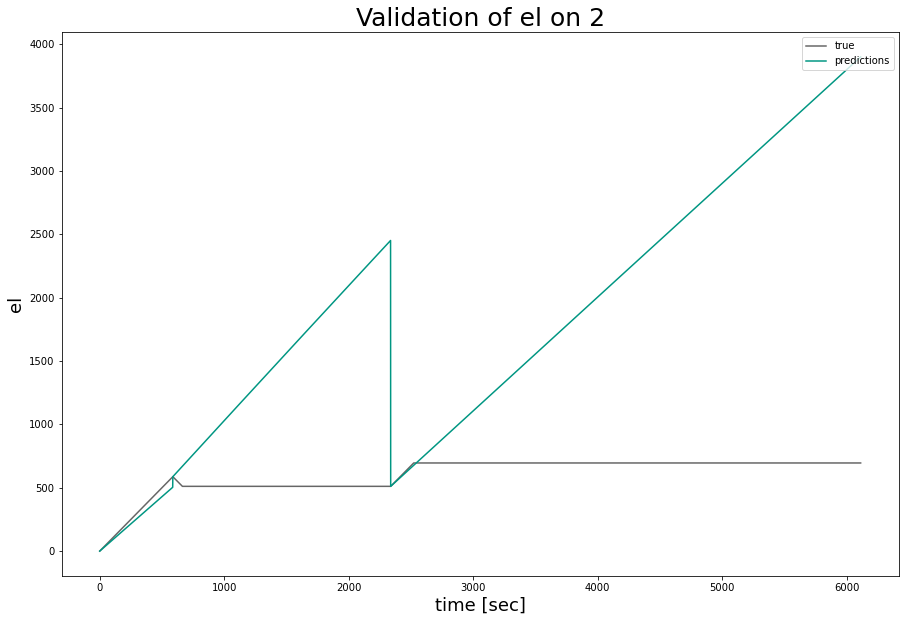

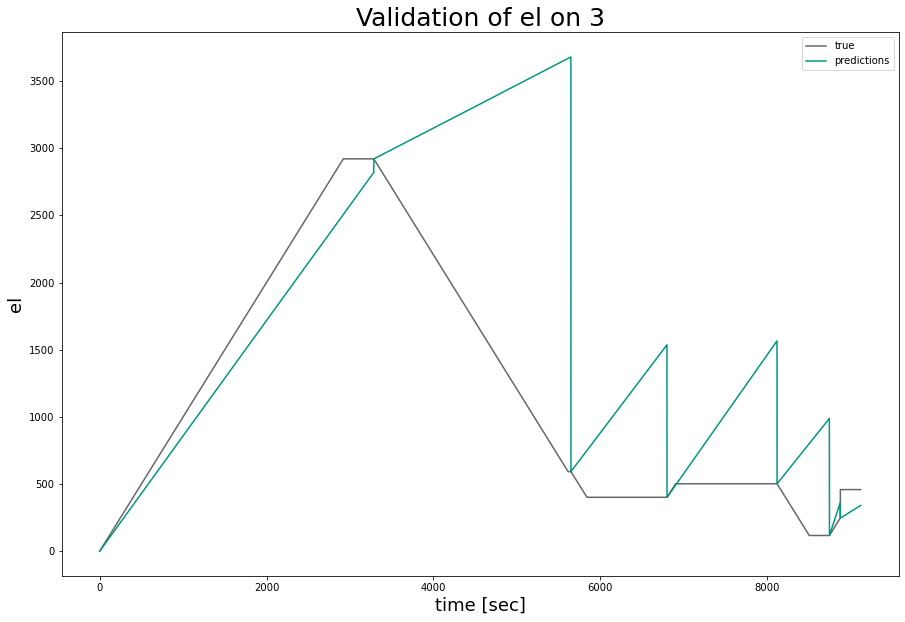

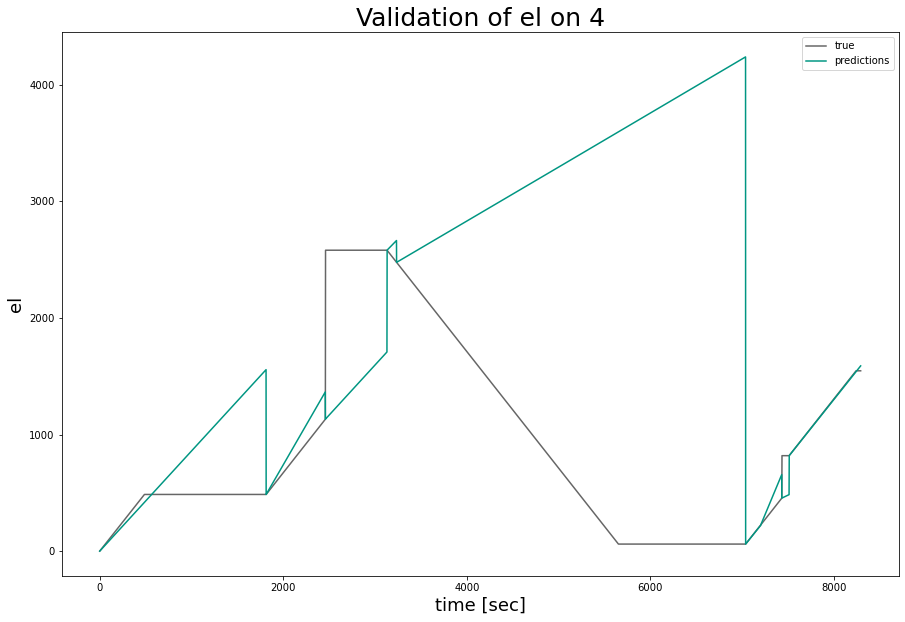

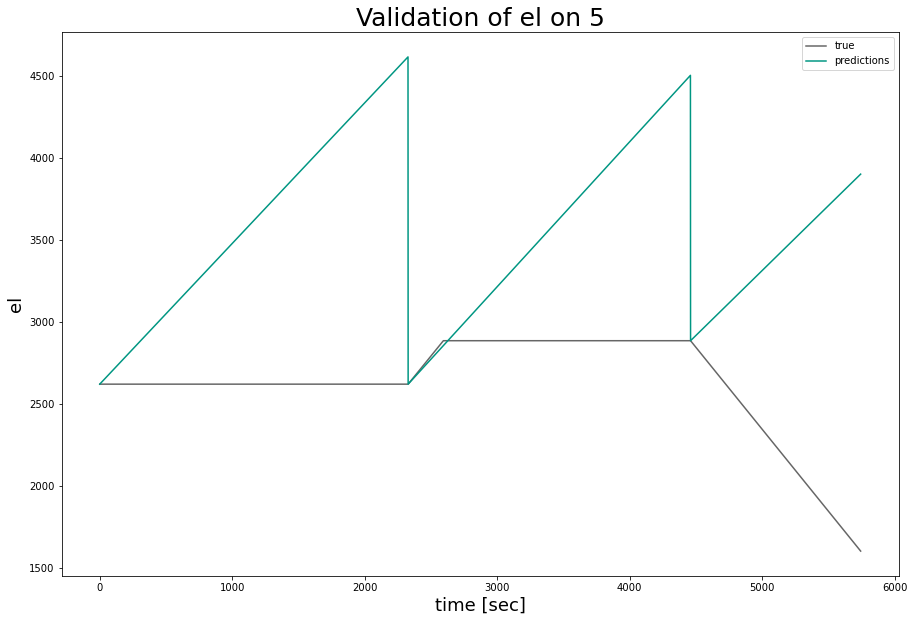

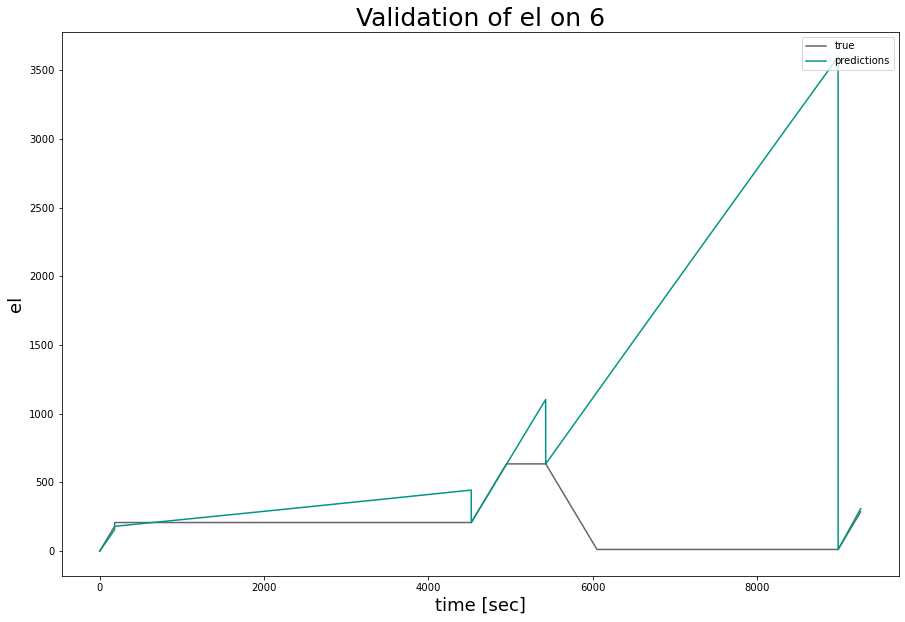

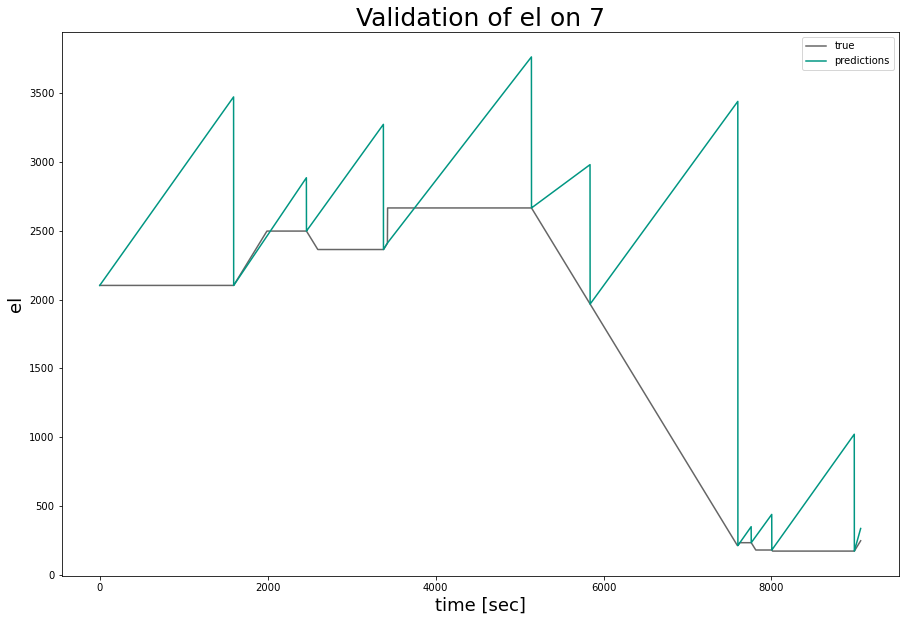

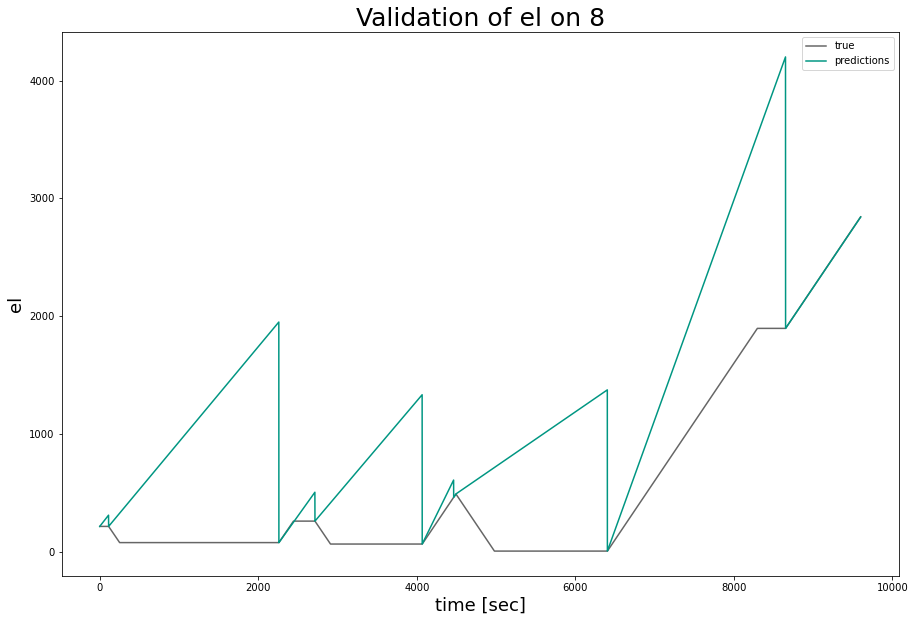

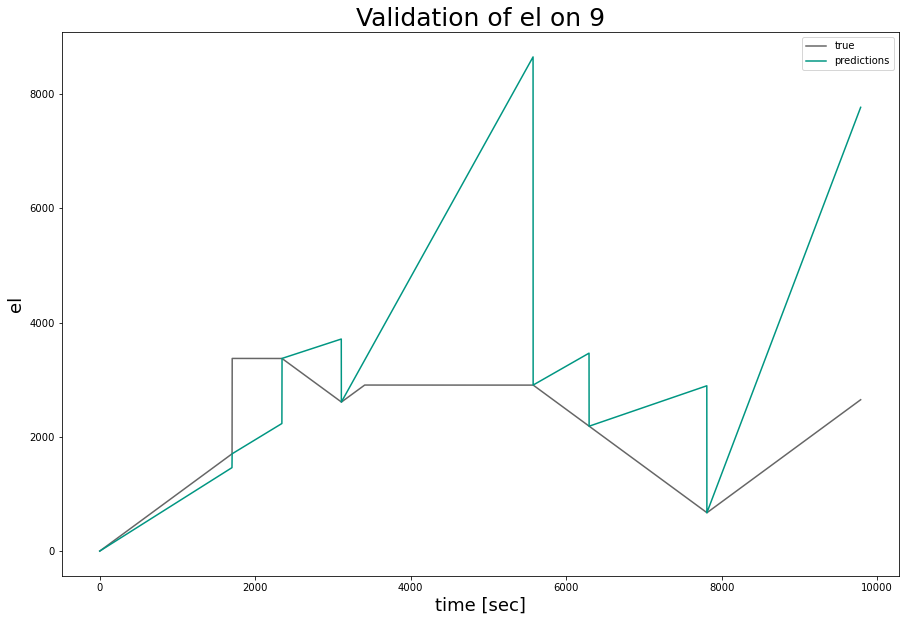

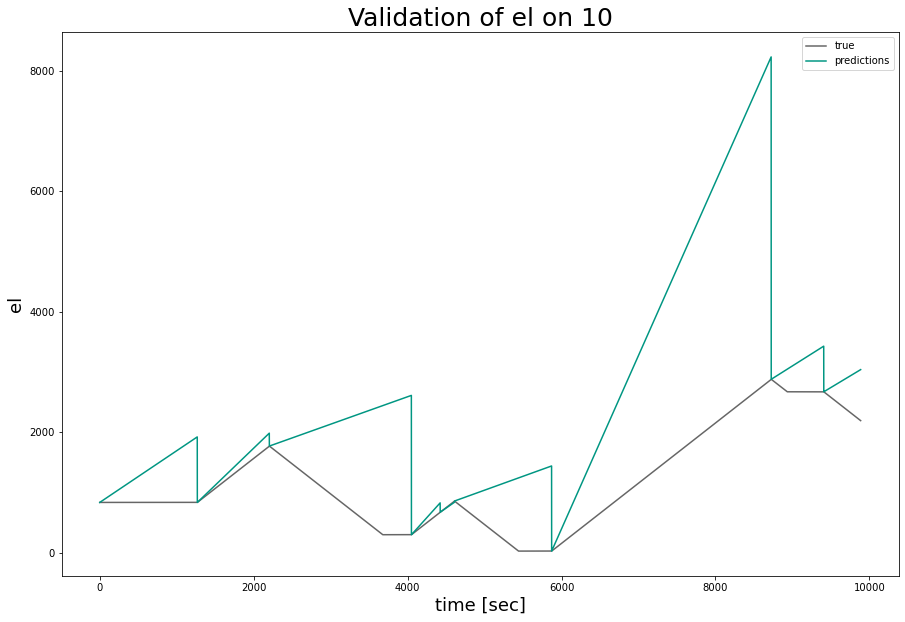

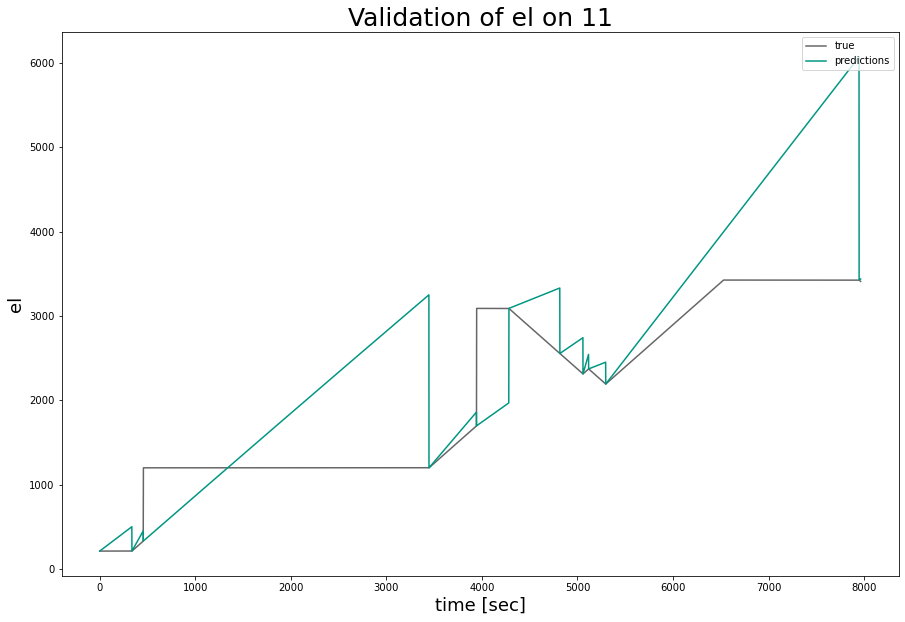

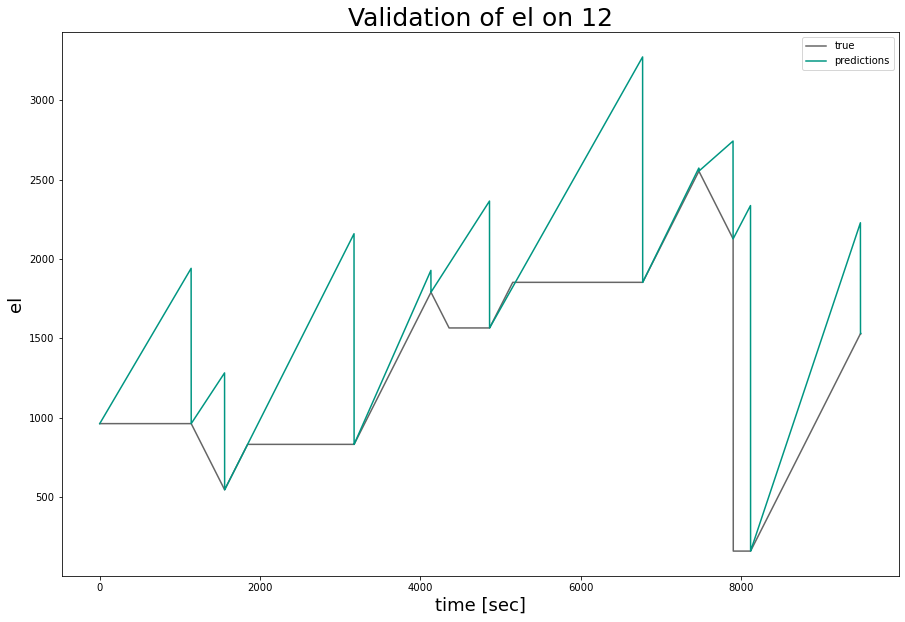

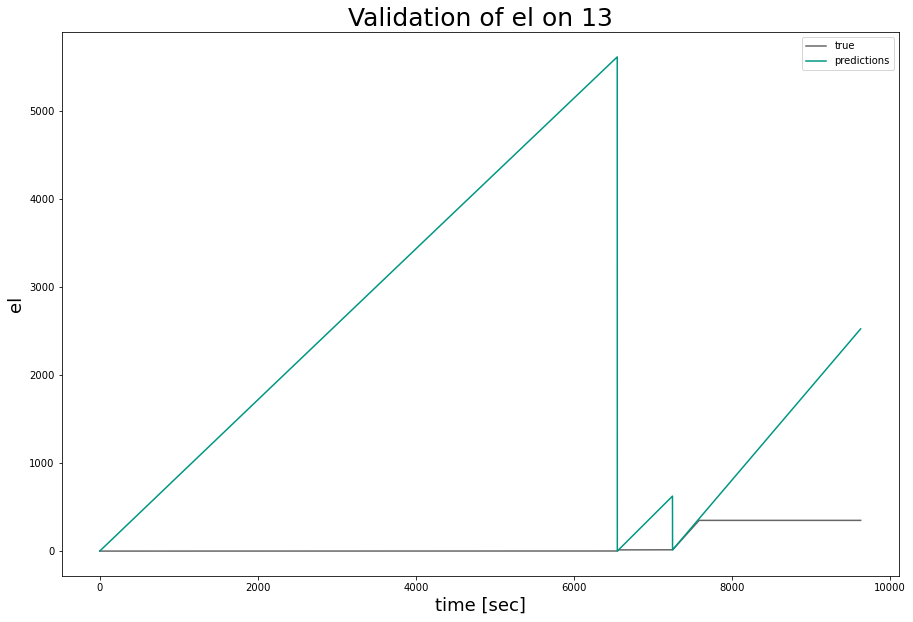

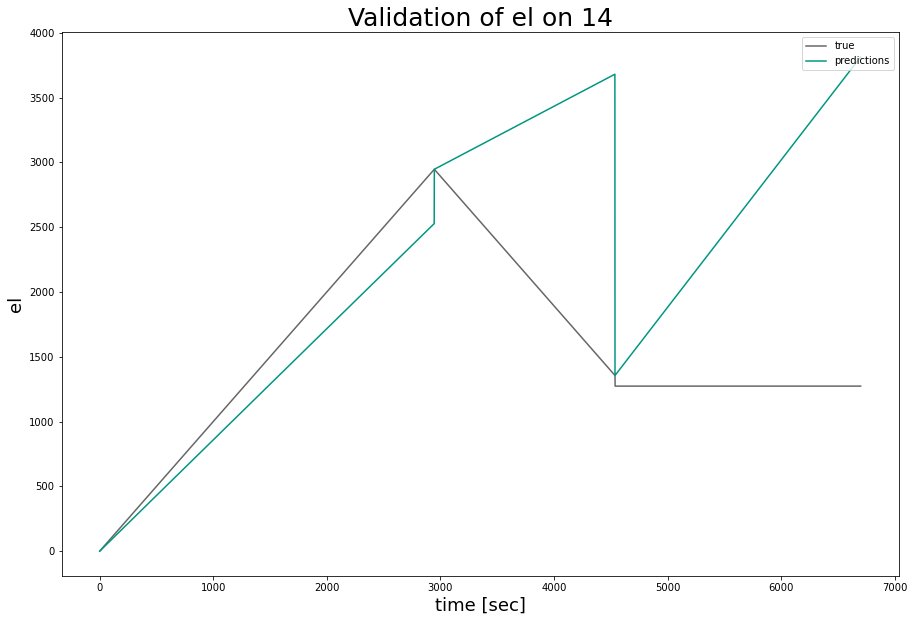

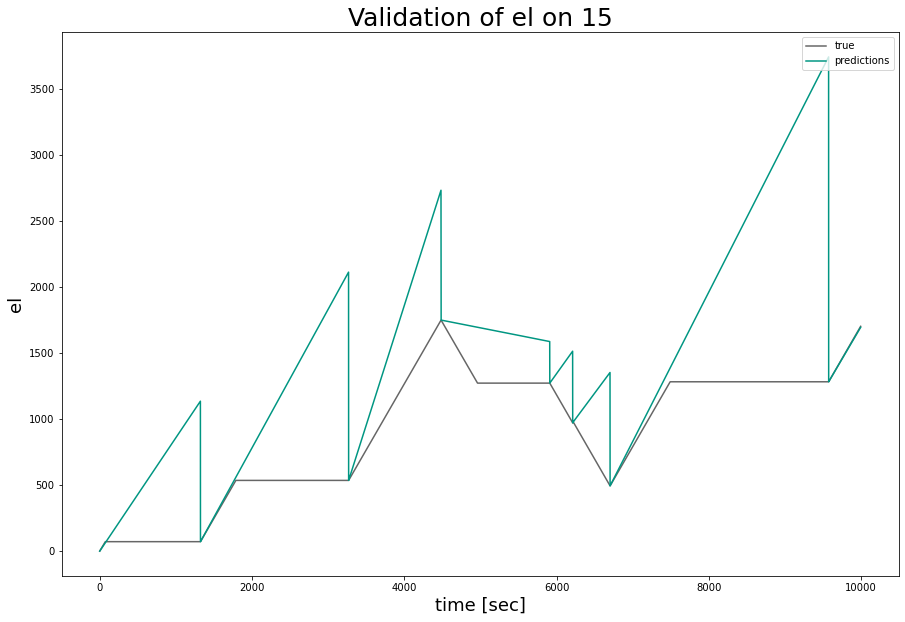

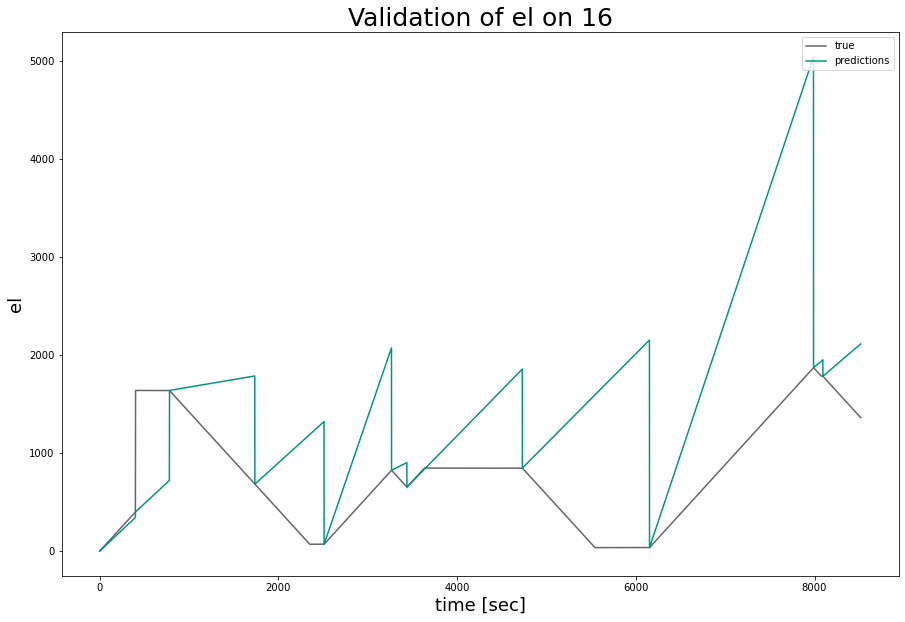

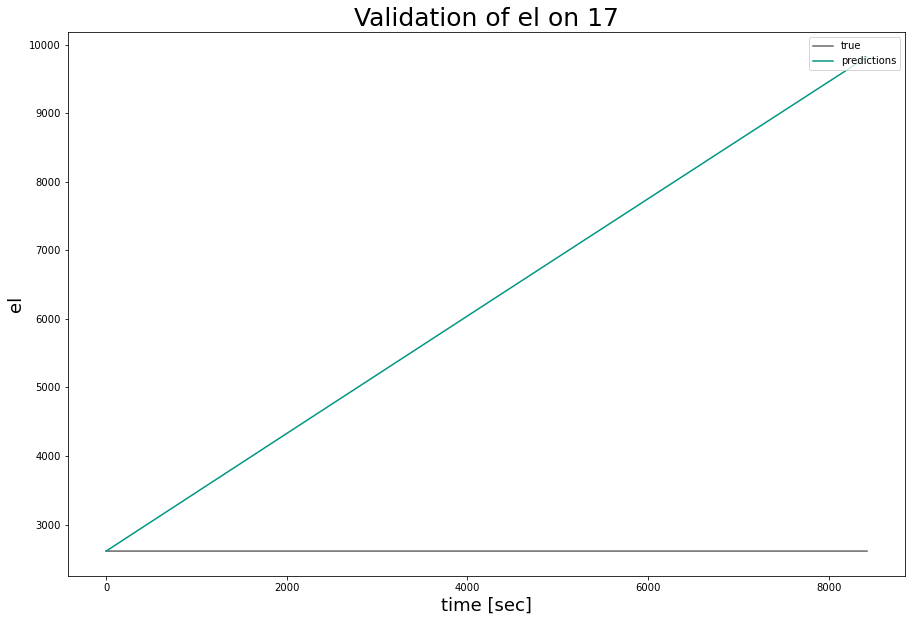

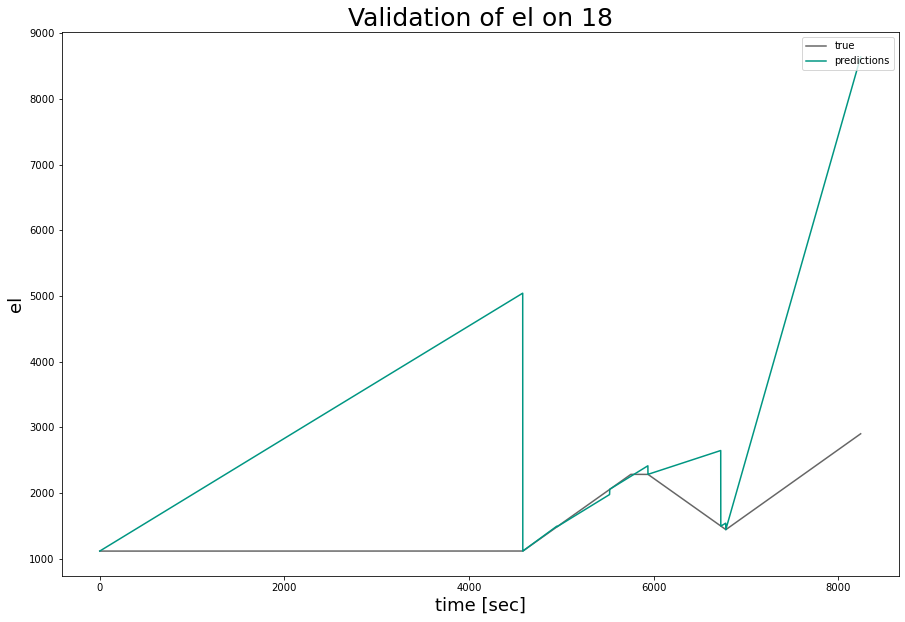

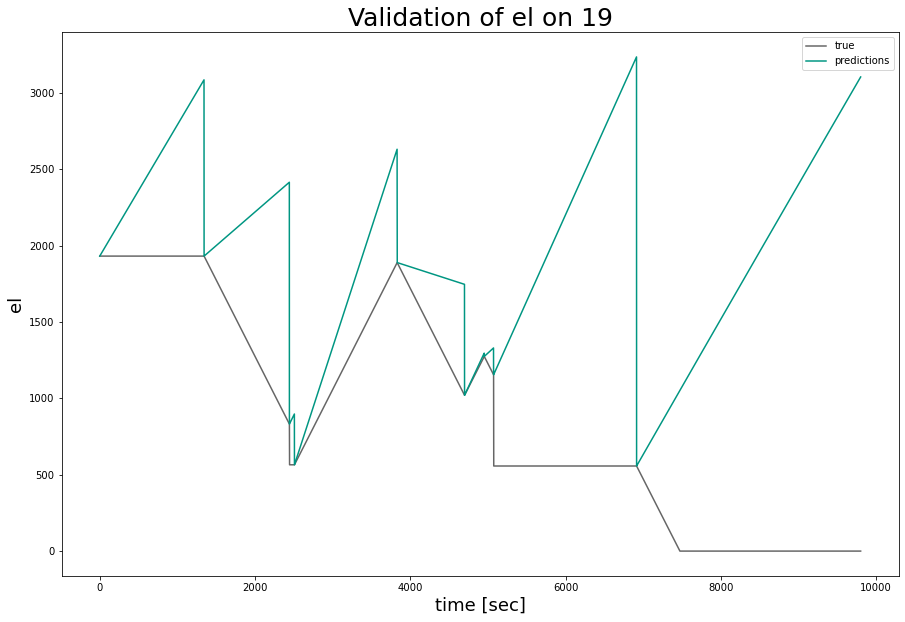

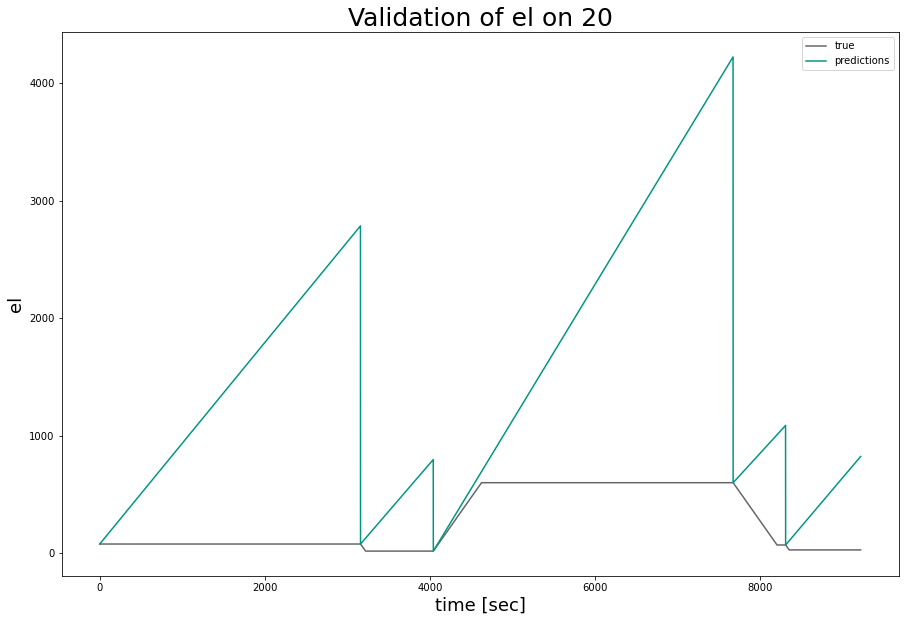

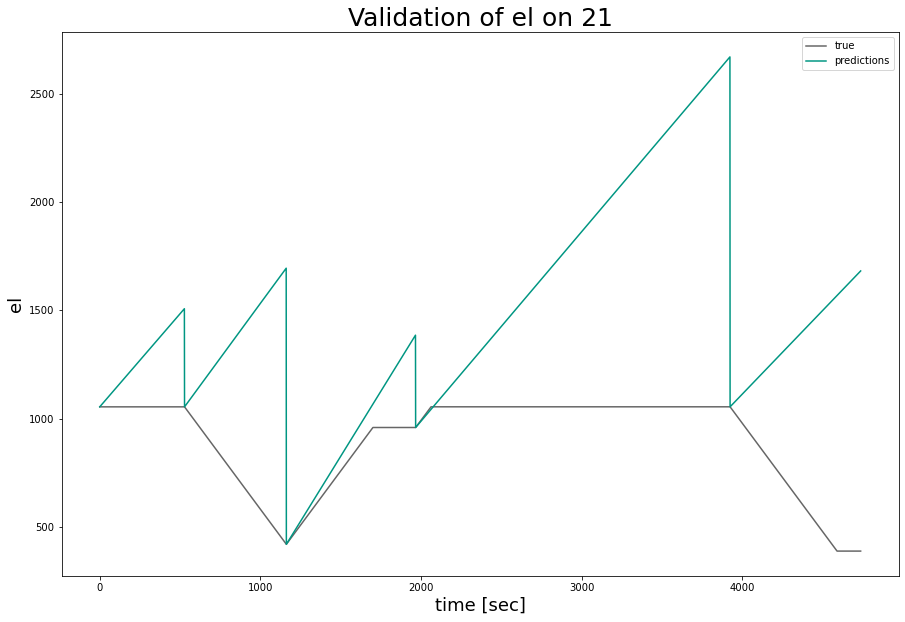

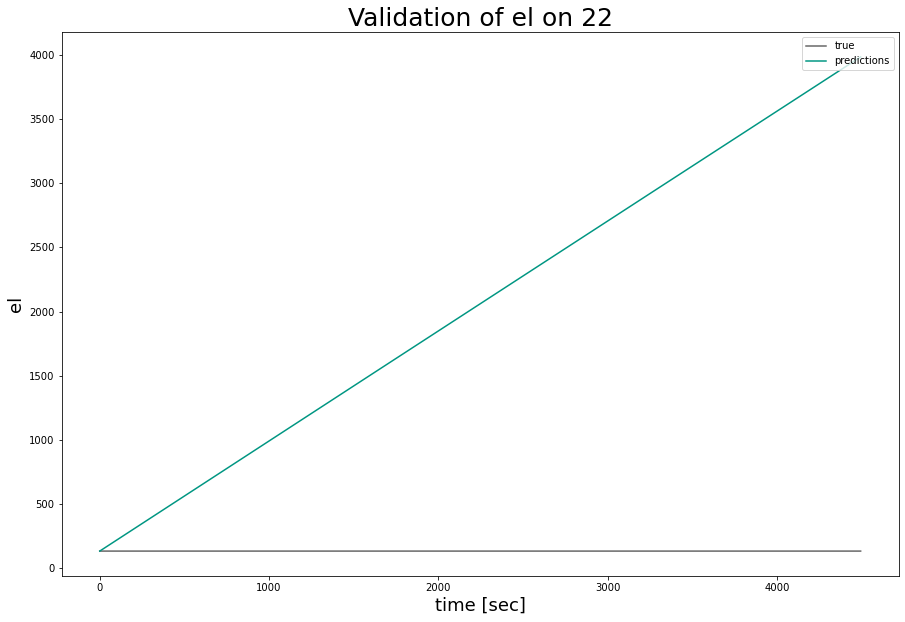

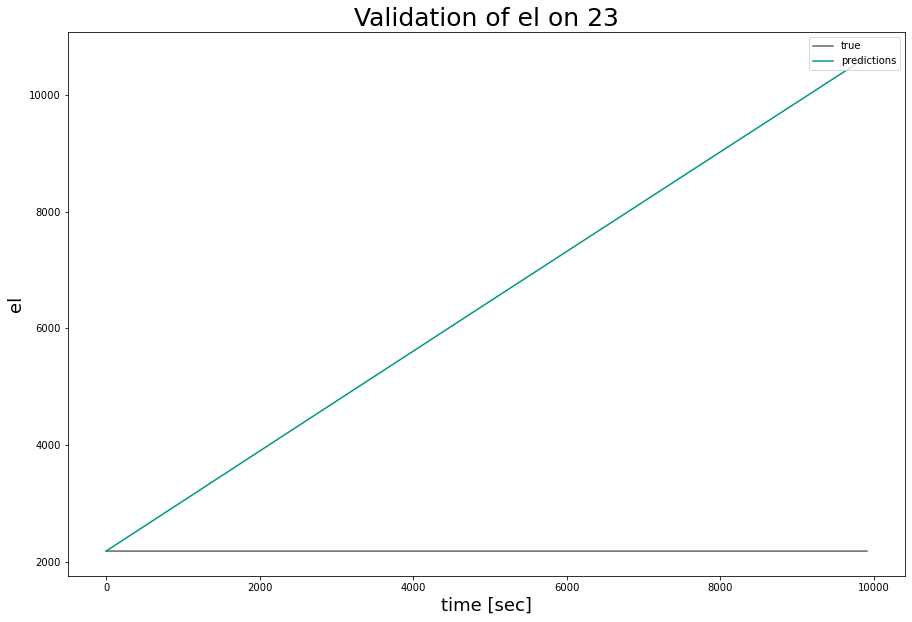

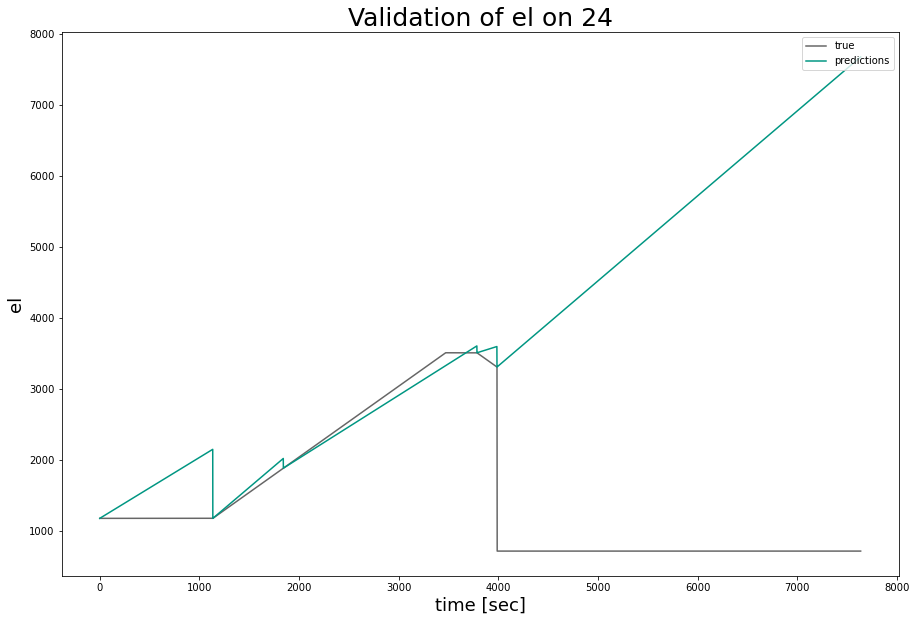

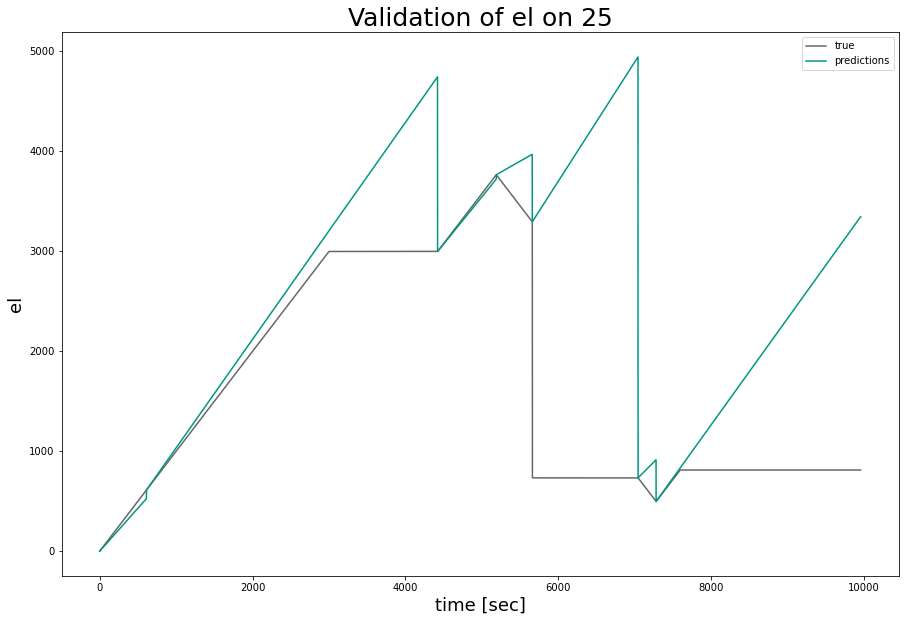

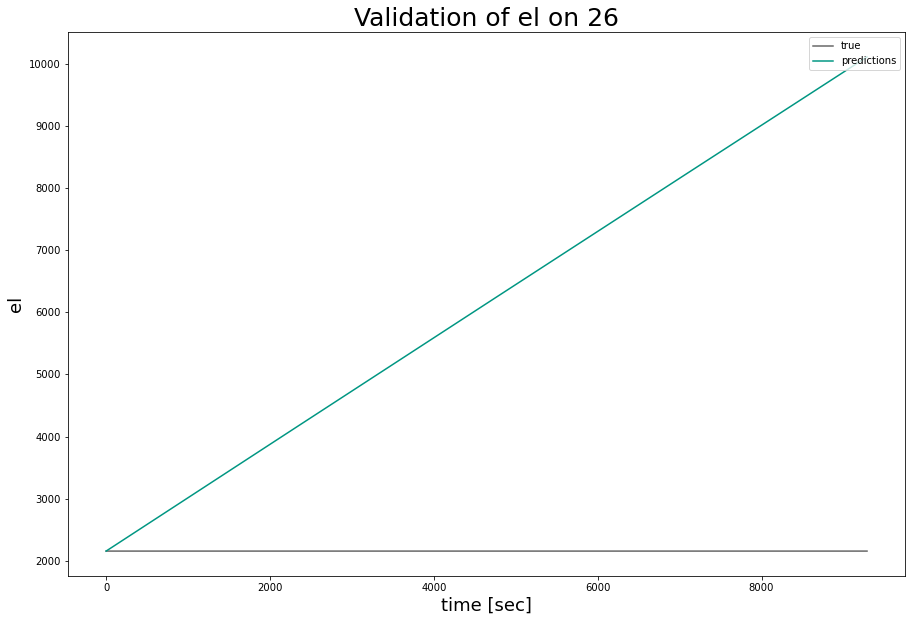

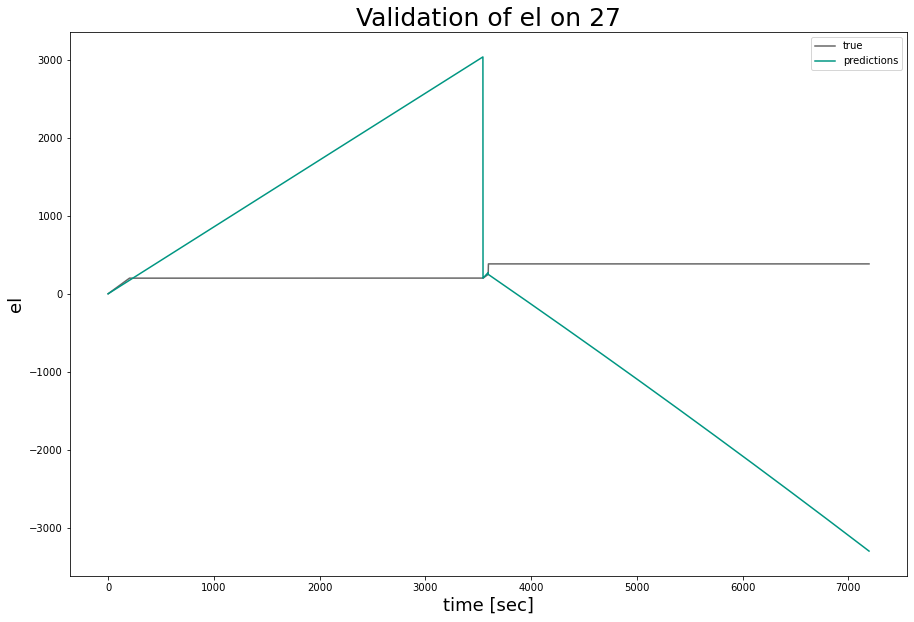

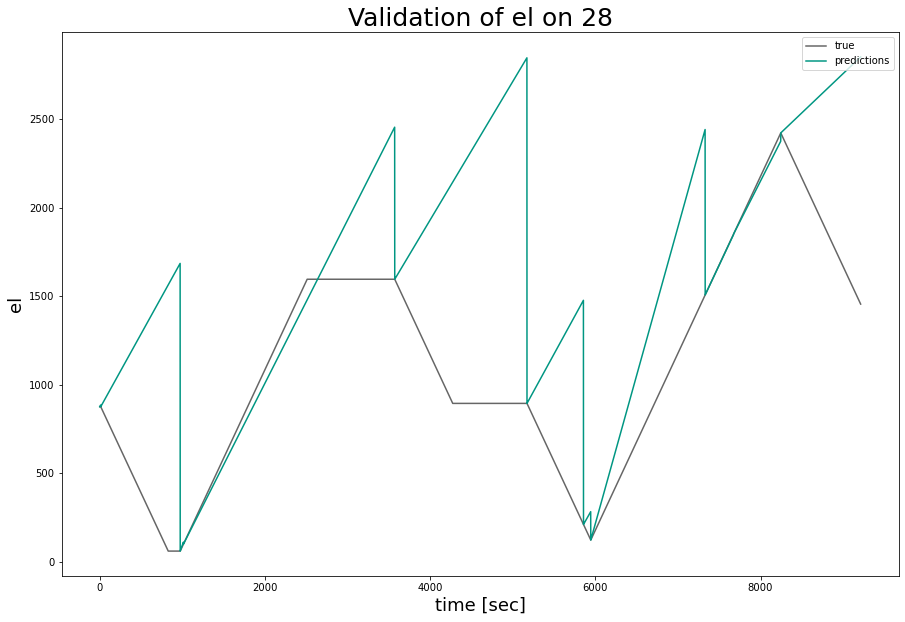

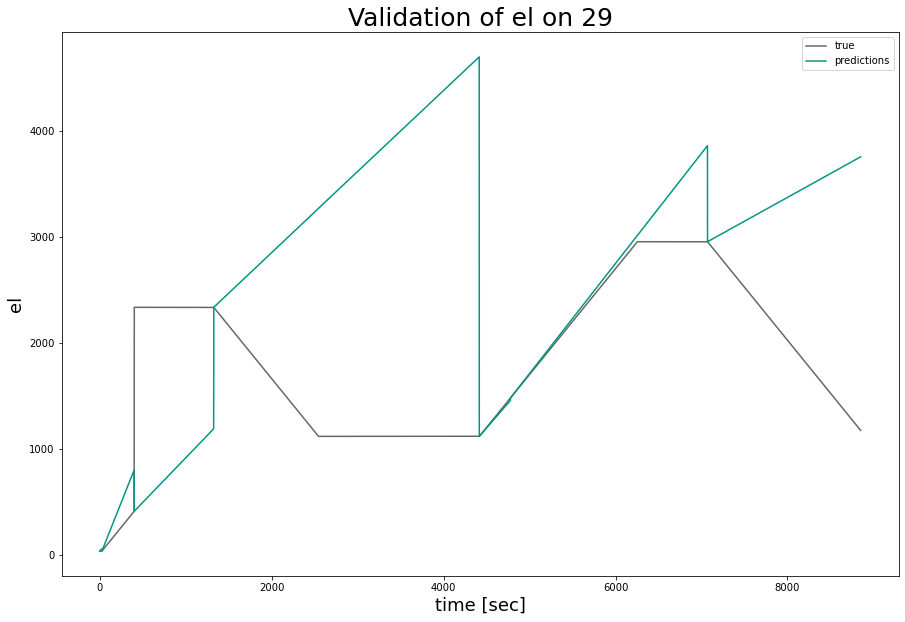

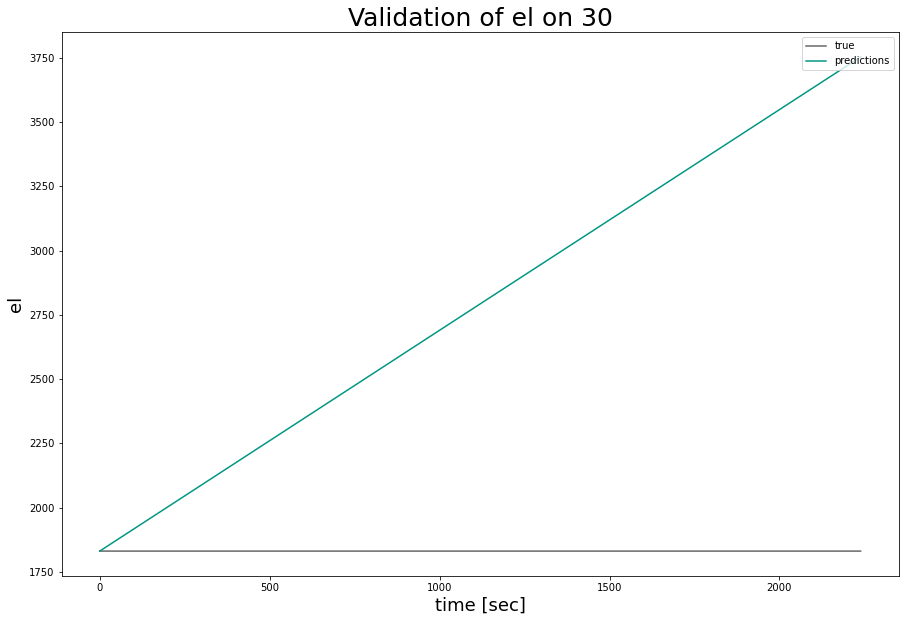

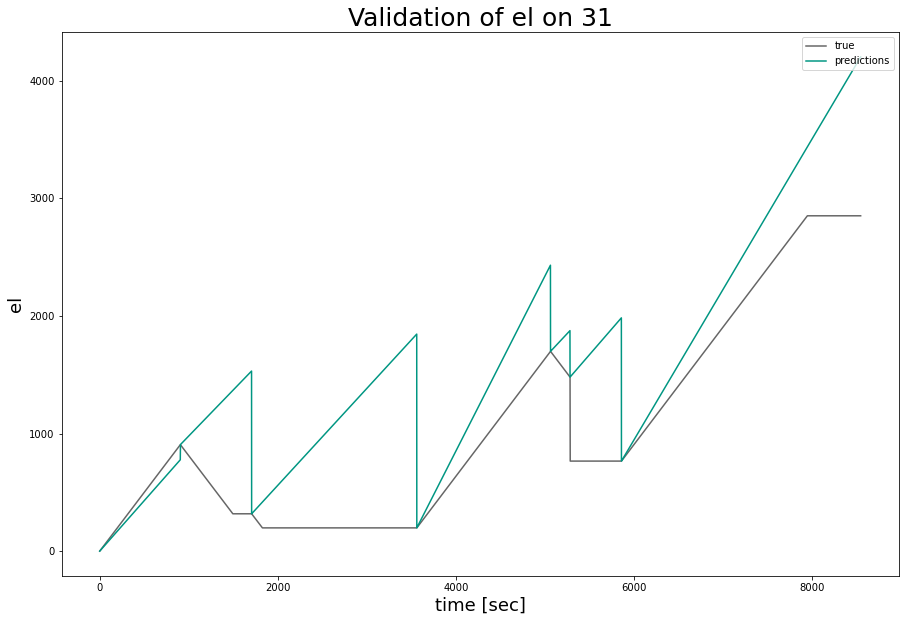

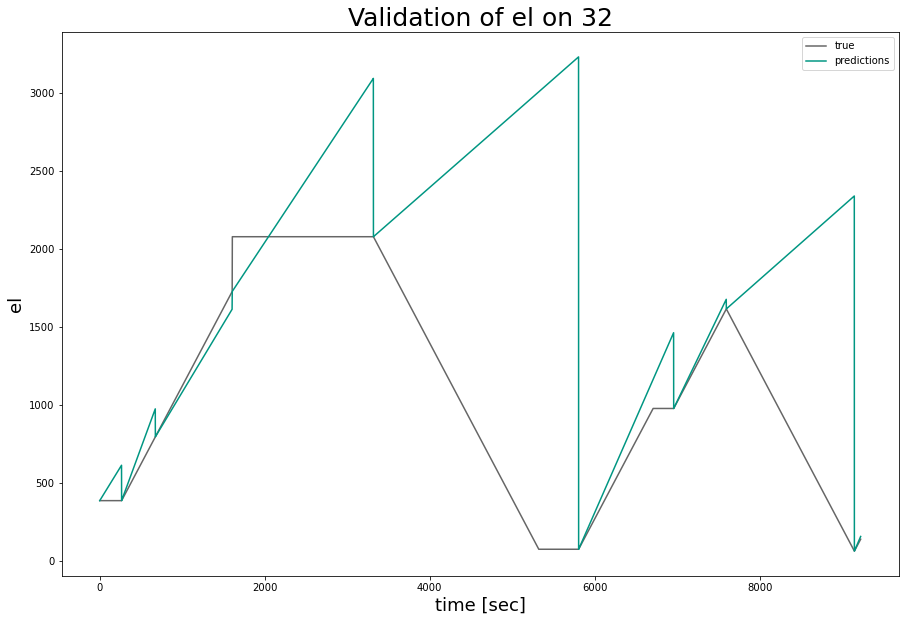

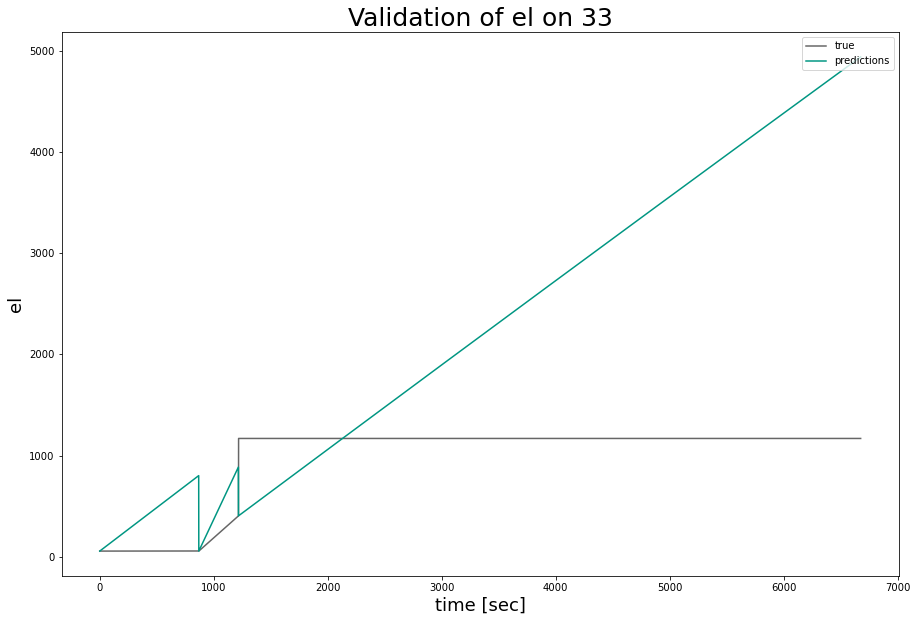

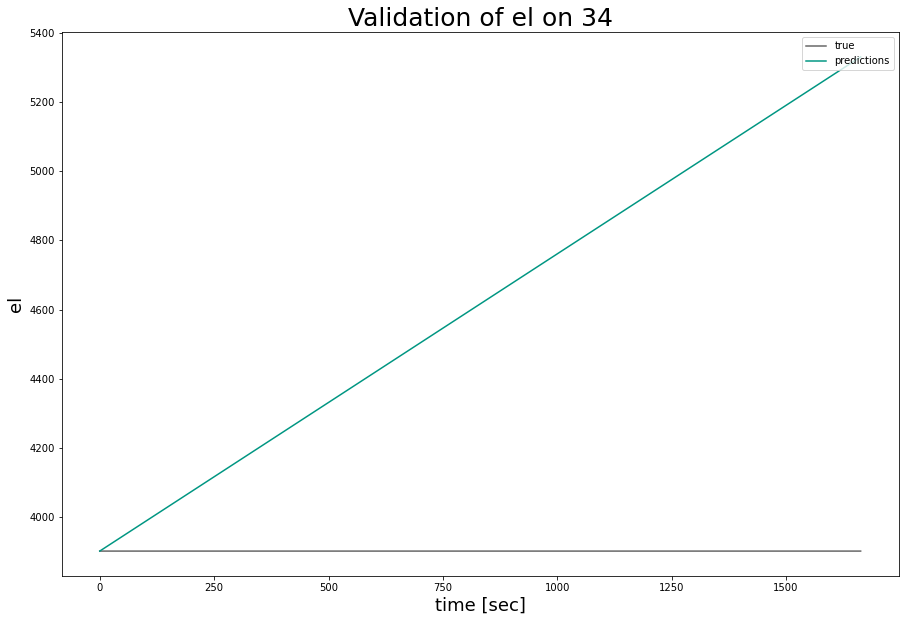

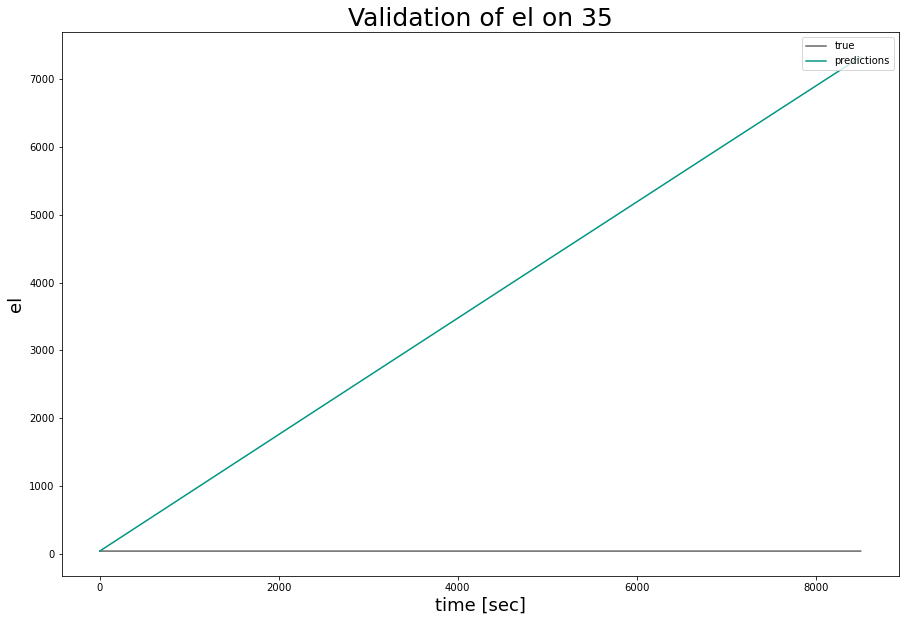

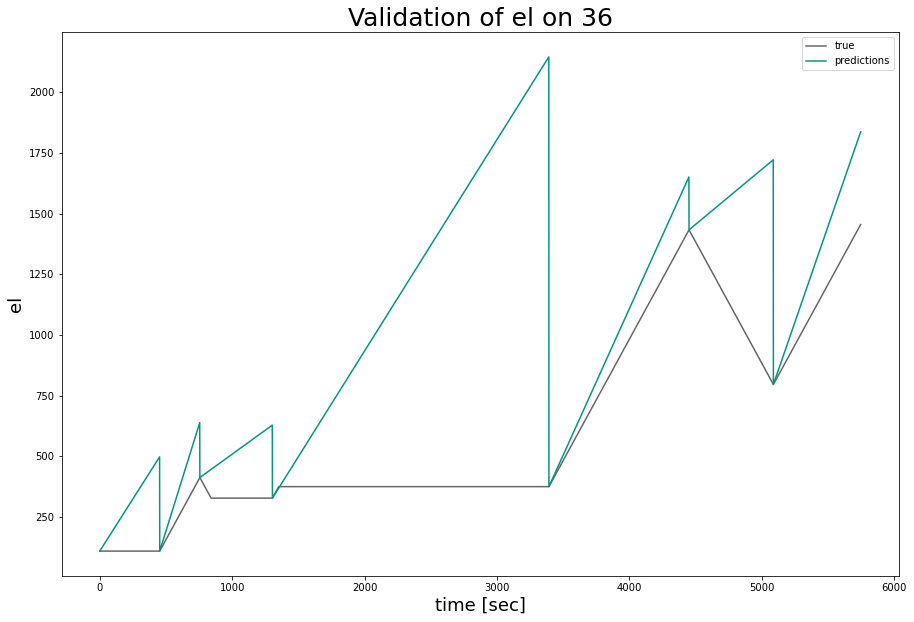

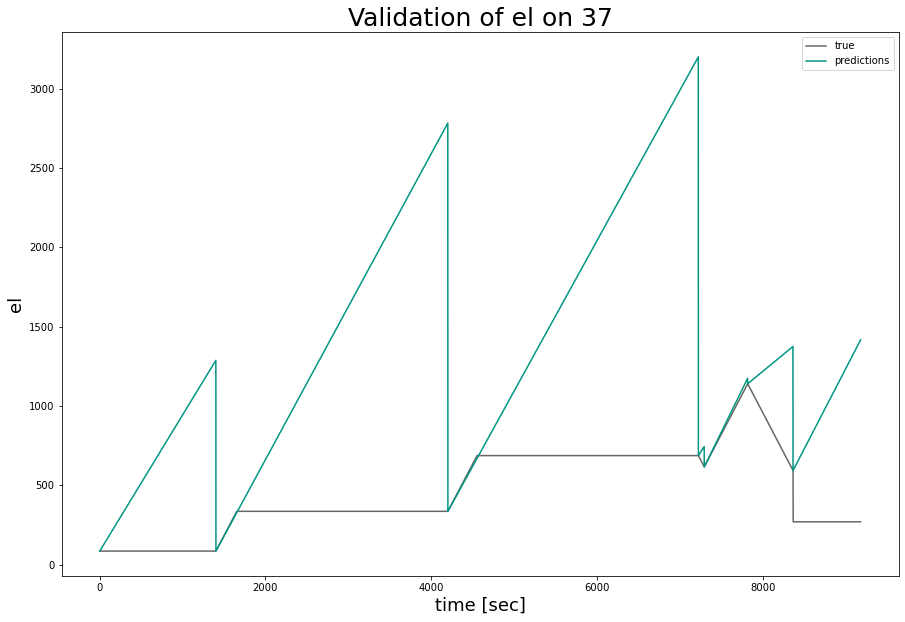

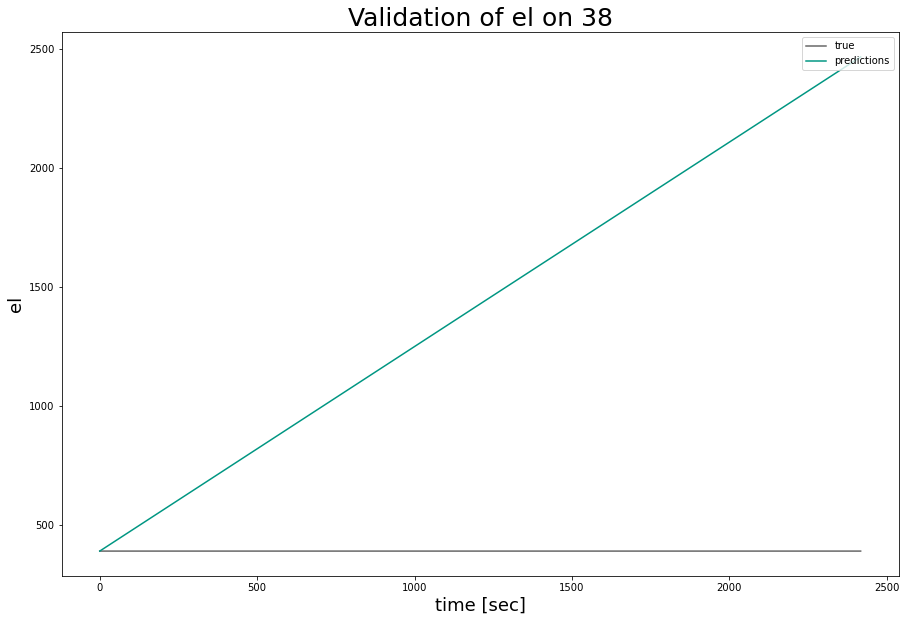

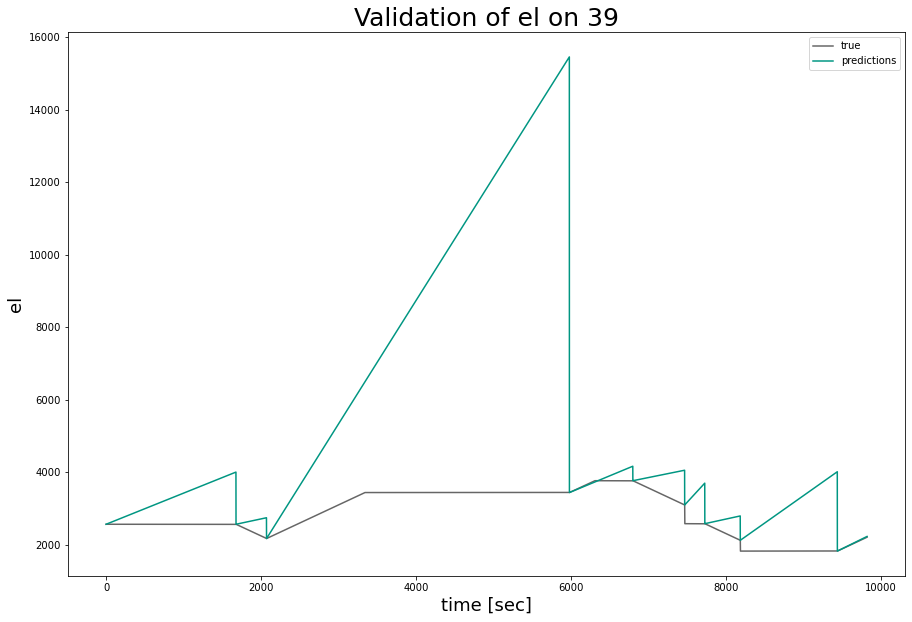

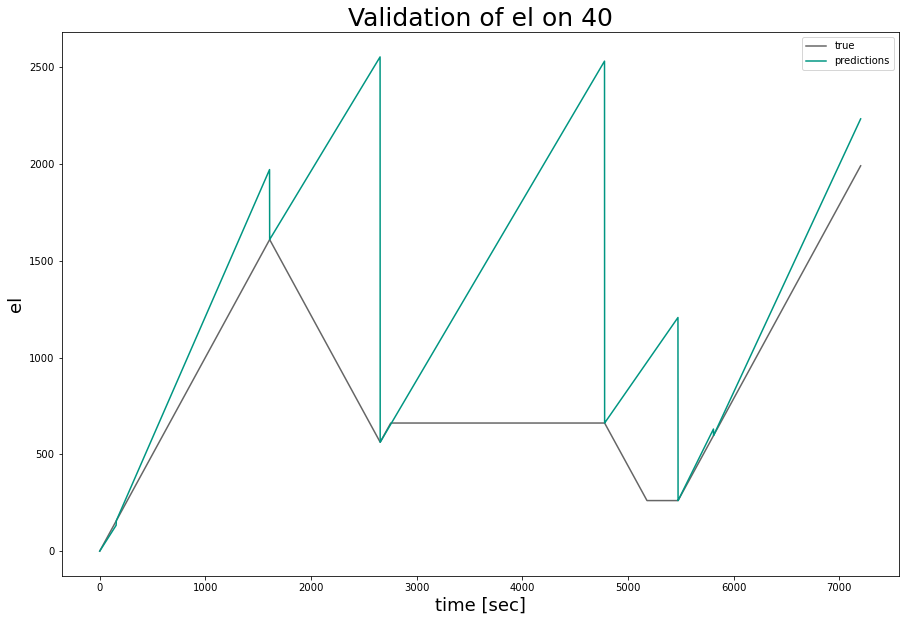

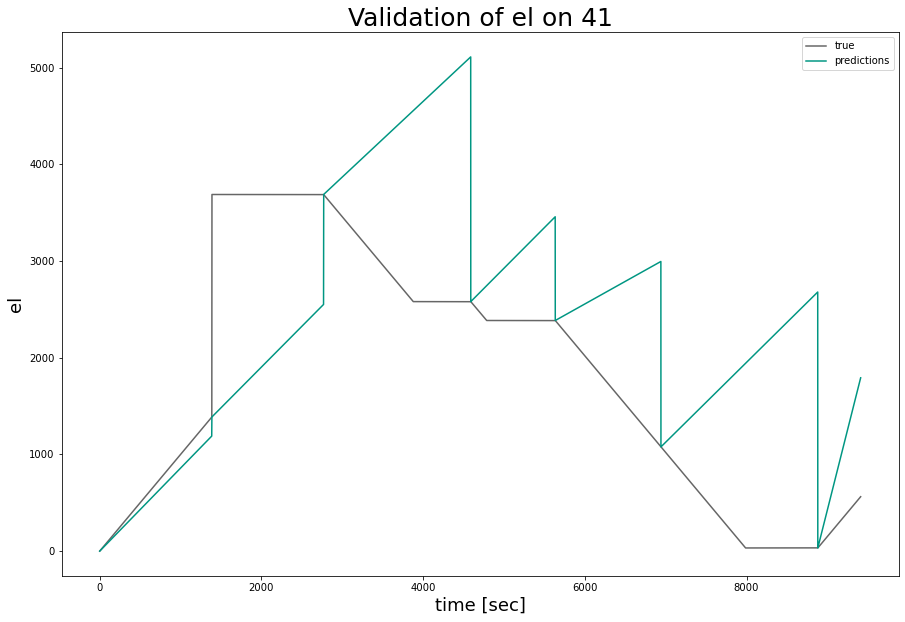

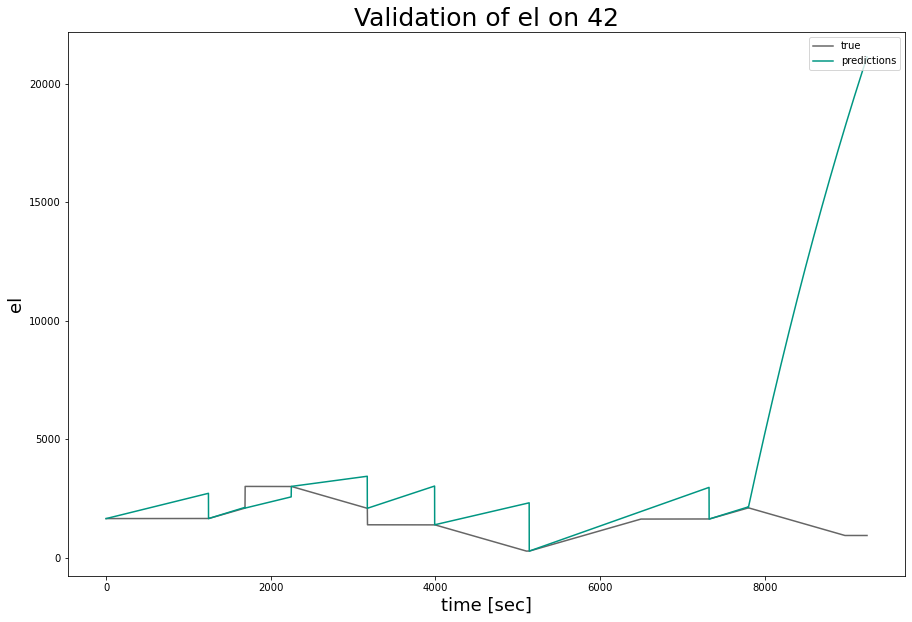

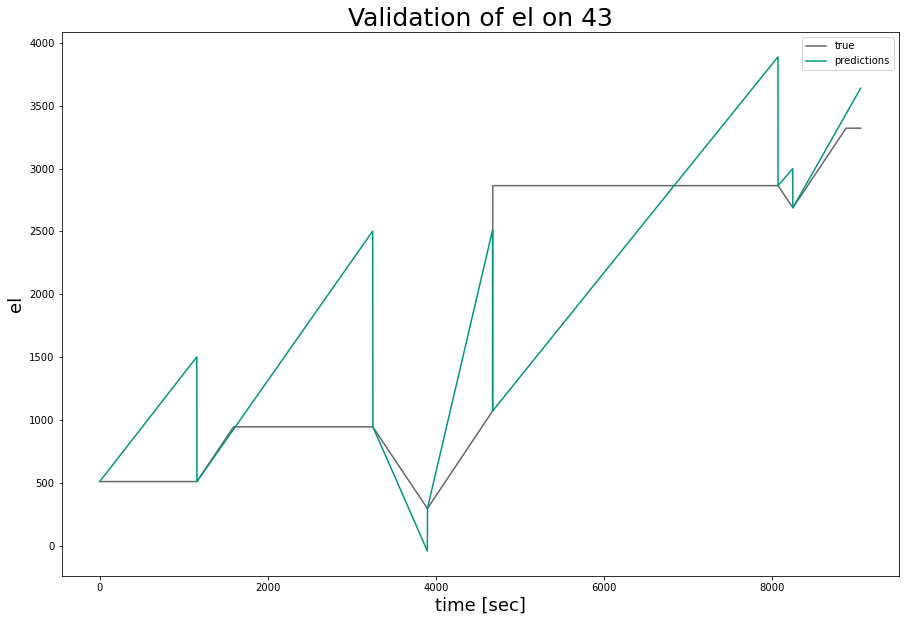

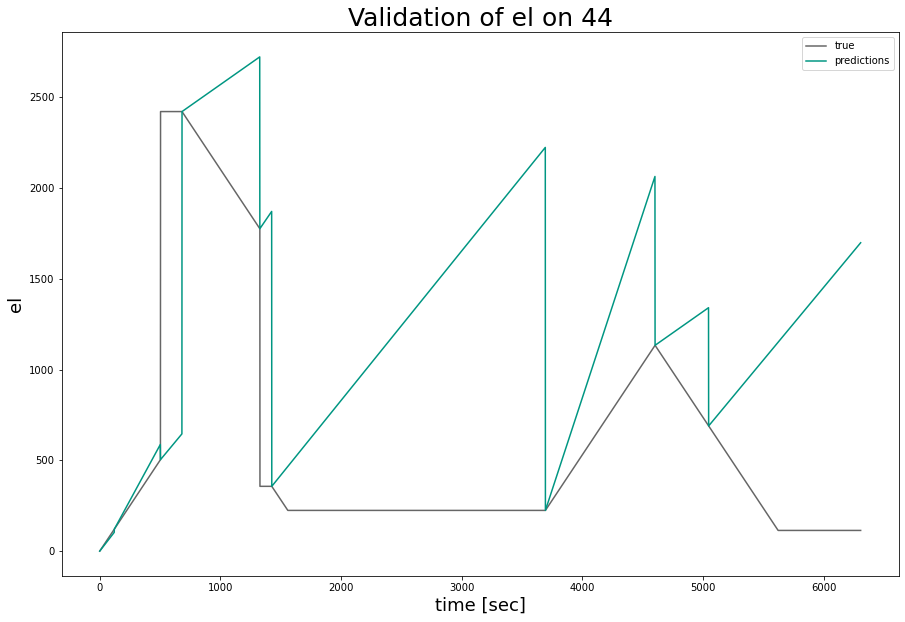

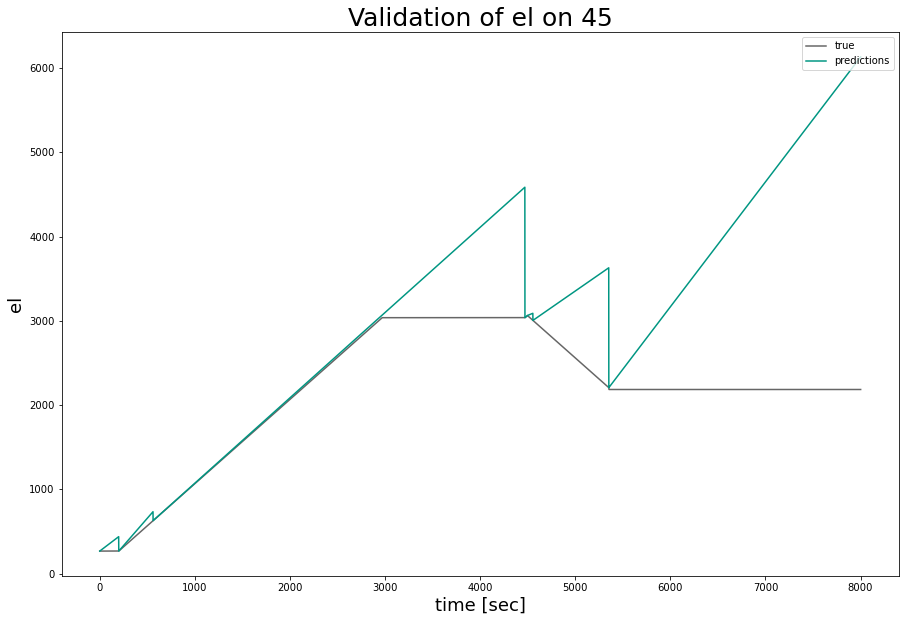

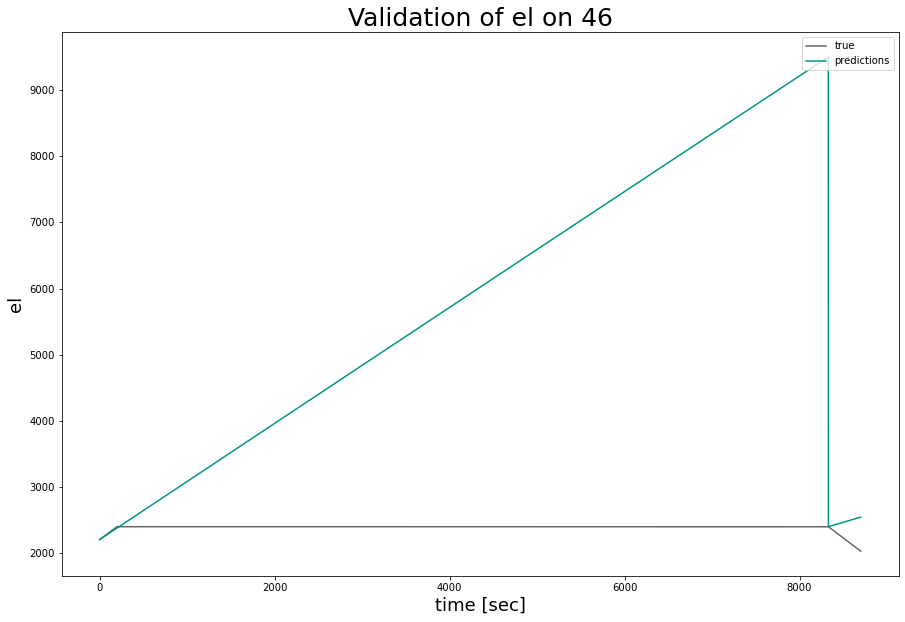

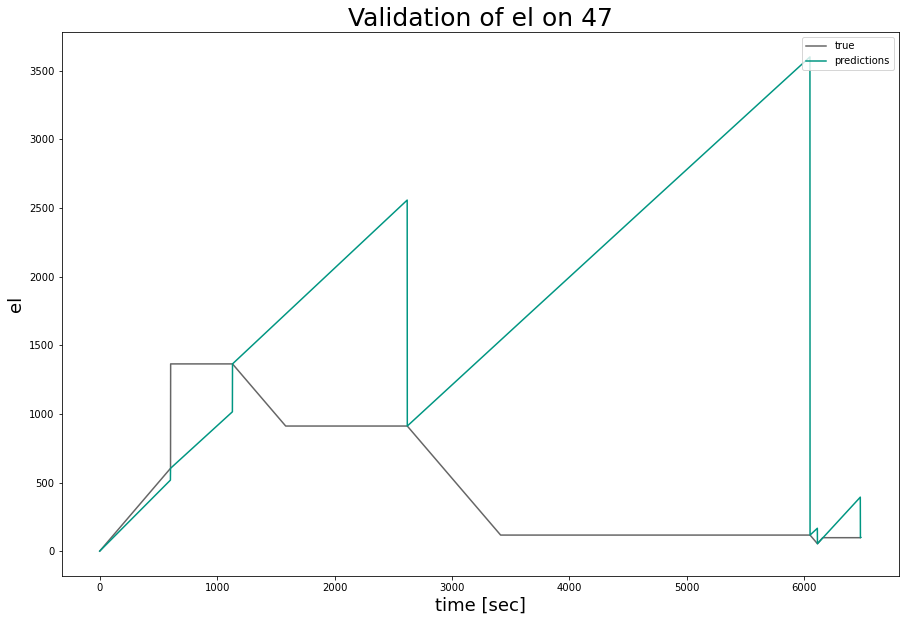

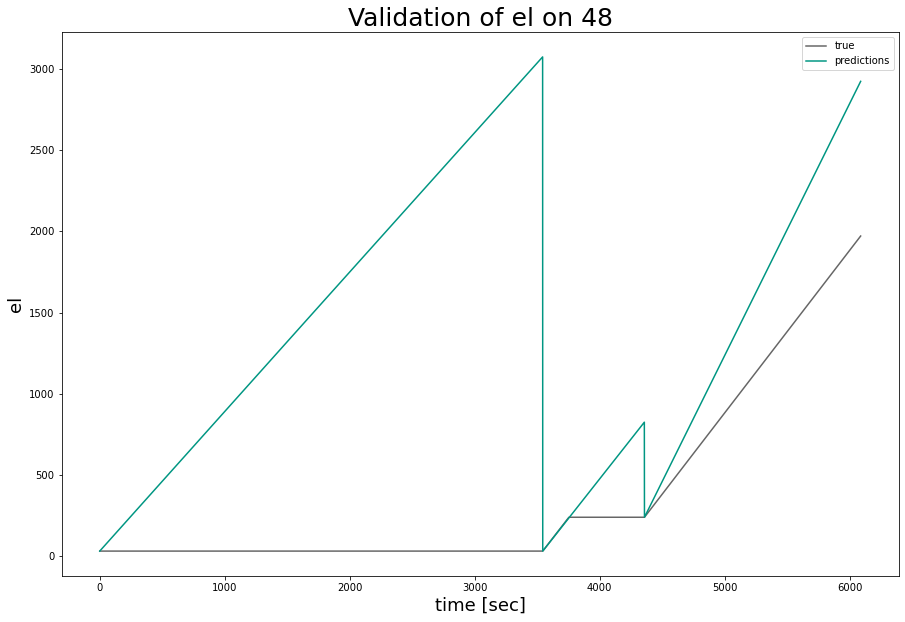

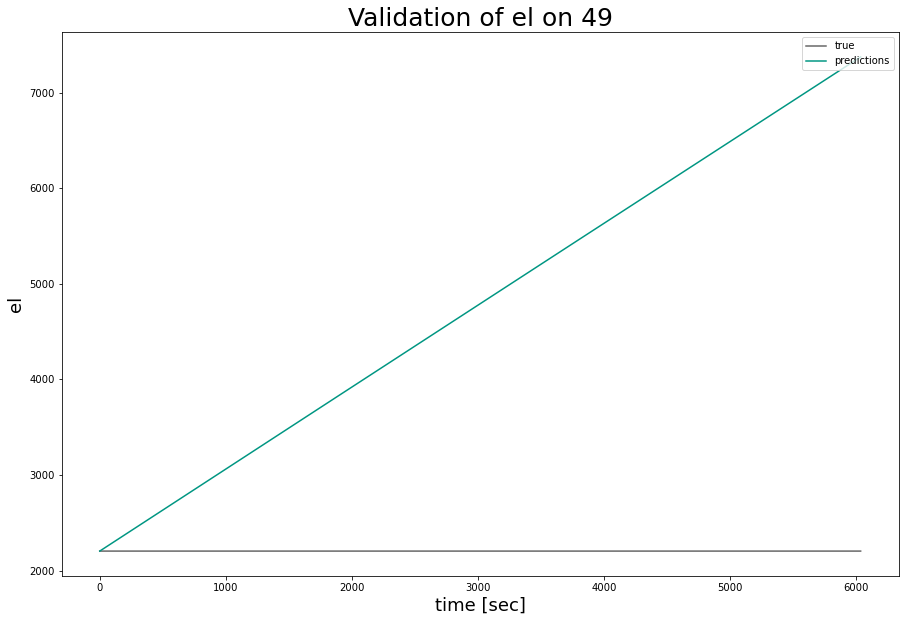

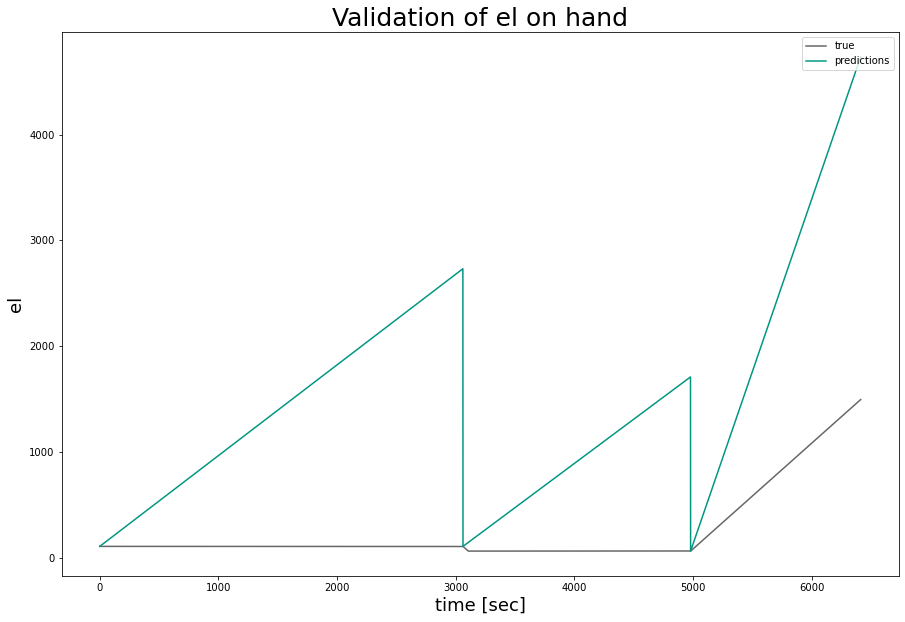

In [25]:
#values = ['spin', 'el', 'th']
values = ['el']
results_df = pd.DataFrame(index = range(len(experiments)), columns = [str(x + "_RMSE") for x in values])

for i in range(len(experiments)):
    res = compare_predictions(experiments[i], names[i], models_1, values)
    results_df.iloc[i] = res[0][0]
    
results_df.to_csv(image_folder + '99_results.csv', sep = "|", encoding="utf-8")

Comparison of predictions using the fits of experiment 4 to true values:

Experiment 1:

Variable|RMSE|R^2|MAX|MaxAE
---|----:|----:|---:|----:
 Spinning  | 1466.611 | -0.559 | 1331.819 | 2182.339
 Electric  | 203.399 | 0.959 | 183.940 | 412.711
 Thermal  | 2190.748 | 0.647 | 1659.354 | 6352.712 

Experiment 9:

Variable|RMSE|R^2|MAE|MaxAE
---|----:|----:|---:|---:
 Spinning  | 25.575 | 0.968 | 19.636 | 53.053 
 Electric  | 101.242 | 0.937 | 82.971 | 285.754 
 Thermal  | 1394.072 | 0.321 | 1111.376 | 3963.333